# Exploration des données

Ce notebook regroupe le travail de nettoyage de données, d'analyse exploratoire et de feauture engeeniring réalisé sur les données de consommation électrique des bâtiments de la ville de Seattle.

## Contexte

La ville de Seattle souhaite atteindre la neutralité carbonne en 2050. Afin d'étudier les modalités de mise en oeuvre, la municipalité a mis à disposition, via [Kaggle](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking), les relevés de consommation d'énergie et d'émission des bâtiments en 2015 et 2016.

L'objectif est d'entraîner une solution de machine learning afin de prédire les émissions de CO2 ( variable GHGEmissions(MetricTonsCO2e))  et la consommation totale d'énergie (variable SiteEnergyUseWN(kBtu)) de bâtiments qui n'ont pas encore fait l'objet de mesures. Nottons que pour la conssommation d'énergie titale, nous privilégions l'utilisation de l'indicateur normalisé par la météo.

Lors des travaux il est également demandé d'évaluer l'intérêt de l'indicateur [ENERGY STAR Score](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results) afin de réaliser les prédictions.

In [1]:
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

## Nettoyage des données

### Choix des variables à prédire

La consommation d'énergie et les émissions de CO2 sont représentées par des variables gloables et des variables ramenées à l'unité de surface (pied carré). Nous décions de poursuivre l'étude sur les variables globales. 
De plus la consommation d'énergie dispose également d'une variable normalisée par les conditions météorologiques. Nous utilisons cette dernières pour les traveaux afin d'éviter des variations liées à la météo. 

Nous utiliserons donc:
- Pour la consommation d'énergie: SiteEnergyUseWN(kBtu)
- Pour les émissions de CO2: GHGEmissions(MetricTonsCO2e) en 2015 / TotalGHGEmissions en 2016

### Dimensions des données

observons les dimensions des jeux de données des deux années pour y déceler des les similitudes et les différences.

In [2]:
data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv", index_col="OSEBuildingID")
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv", index_col="OSEBuildingID")
display(data_2015.head())
print(f"Dimensions des données en 2015 : {data_2015.shape[0]} observations / {data_2015.shape[1]} variables")
display(data_2016.head())
print(f"Dimensions des données en 2016 : {data_2016.shape[0]} observations / {data_2016.shape[1]} variables")

,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


Dimensions des données en 2015 : 3340 observations / 46 variables


,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Dimensions des données en 2016 : 3376 observations / 45 variables


On constate à la fois un différenciel sur le nombre d'observations et de varibales. Quantifions la différence de lignes et observons les différences de variables.

In [3]:
cols_2015 = set(data_2015.columns)
cols_2016 = set(data_2016.columns)
cols_difs_2015 = cols_2015.difference(cols_2016)
cols_difs_2016 = cols_2016.difference(cols_2015)
cols_inter = cols_2015.intersection(cols_2016)
print(f"Différentiel du nombre d'obsrevation 2016 vs 2015: {data_2016.shape[0] - data_2015.shape[0]}\n")
print(f"Nombre de variables présentes dans les deux relevés de 20156 et 2016: {len(cols_inter)}\n")
print("Variables partagées par les deux relevés de 2015 et 2016:")
display(cols_inter)
print("\n")
print("-"*50)
print("\n")
print(f"Nombre de variables présentes en 2015 mais absentes en 2016: {len(cols_difs_2015)}\n")
print("Variables présentes en 2015 et absente en 2016")
display(cols_difs_2015)
print("\n")
print("-"*50)
print("\n")
print(f"Nombre de variables présentes en 2016 mais absentes en 2015: {len(cols_difs_2016)}\n")
print("Variables présentes en 2016 mais absentes en 2015:")
display(cols_difs_2016)

Différentiel du nombre d'obsrevation 2016 vs 2015: 36

Nombre de variables présentes dans les deux relevés de 20156 et 2016: 36

Variables partagées par les deux relevés de 2015 et 2016:


{'BuildingType',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DataYear',
 'DefaultData',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'Electricity(kWh)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NaturalGas(kBtu)',
 'NaturalGas(therms)',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'Outlier',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SteamUse(kBtu)',
 'TaxParcelIdentificationNumber',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearBuilt',
 'YearsENERGYSTARCertified'}



--------------------------------------------------


Nombre de variables présentes en 2015 mais absentes en 2016: 10

Variables présentes en 2015 et absente en 2016


{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}



--------------------------------------------------


Nombre de variables présentes en 2016 mais absentes en 2015: 9

Variables présentes en 2016 mais absentes en 2015:


{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

Les différentes d'observations peuvent potentiellement s'expliquer par la mise en service de nouveaux bâtiments ou leur démolition entre les deux relevés.

En ce qui concernerne les différence de varibale nous pouvons constater deux cas:
- Deux variables au noms différents aux valeurs simmilaires:
    - "Comments" en 2015 et "Comment" en 2016
    
    
- Deux différents encodages de la même information. Dans cette catégorie figurent:
    - la varibale "Location" en 2015 décomposée en "Latitude" et "Longitude" en 2016
    
    
- Variales au noms proches mais avec des valeurs différentes sur les mêmes observations
    - la variable "Zip Codes" en 2015 et "ZipCode" en 2016
    - la variable "GHGEmissionsIntensity(kgCO2e/ft2)" en 2015 et "'GHGEmissionsIntensity" en 2016
    
    
- Variables présentes que dans un des deux relevés:
    - "2010 Census Tracts" (2015)
    - "City Council DIstricts" (2015)
    - "GHGEmissions(MetricTonsCO2e)" (2015)
    - "SPD Beats"
    - "Seattle Police Department Micro Community Policing Plan Areas"
    - "Address" (2016)
    - "City" (2016)
    - "State" (2016)
    - "TotalGHEmissions" (2016)
    

Observons maintenant les différences d'indexes des observations de chaque année.

In [4]:
idx_2015 = set(data_2015.index)
idx_2016 = set(data_2016.index)
print(f"Nombre d'observations du relevé de 2015 {len(idx_2015)}")
print(f"Nombre d'observations du relevé de 2016 {len(idx_2016)}")
print(f"Nombre d'observartion total des deux relevés {len(idx_2015 | idx_2016)}")
print(f"Nombre d'observations présentes dans les deux relevés {len(idx_2015 & idx_2016)}")
print(f"Nombre d'observations présentes dans le relevé de 2015 mais pas dans le relevé de 2016 {len(idx_2015 - idx_2016)}")
print(f"Nombre d'observation présentes dans le relevé de 2016 mais pas dans le relevé de 2015 {len(idx_2016 - idx_2015)}")

Nombre d'observations du relevé de 2015 3340
Nombre d'observations du relevé de 2016 3376
Nombre d'observartion total des deux relevés 3432
Nombre d'observations présentes dans les deux relevés 3284
Nombre d'observations présentes dans le relevé de 2015 mais pas dans le relevé de 2016 56
Nombre d'observation présentes dans le relevé de 2016 mais pas dans le relevé de 2015 92


On constate un nombre restraint d'obserbvations présentes dans une relevé mais pas dans un autre. Plusieurs hypothèse s'avèrent possibles pour expliquer le phénomène:
- Inauguration de nouveaux bâtiments
- Destruction de bâtiments
- Travaux

La conséquence est qu'une majorité d'observation a fait l'objet de deux relevés de consommation énergétique. En conséquence il sera potentionnellement nécesssaire d'entraîner des modèles pour chaque année.
Vérifions sur les données qui ont fait l'objet de deux relevés si les données de consommation d'énergie et d'émissions de CO2 ont des distributions similaires. 

Distribution de la variable SiteEUIWN(kBtu) en 2015


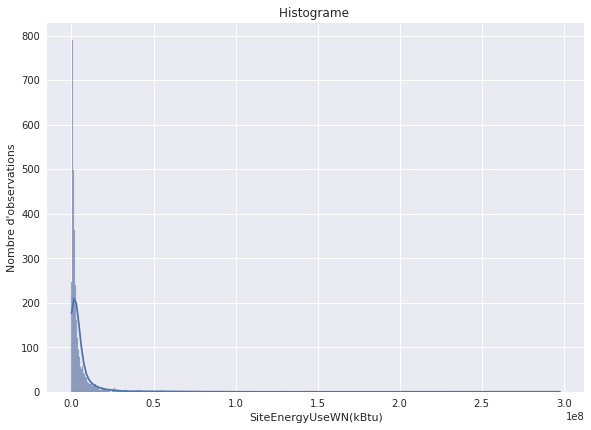

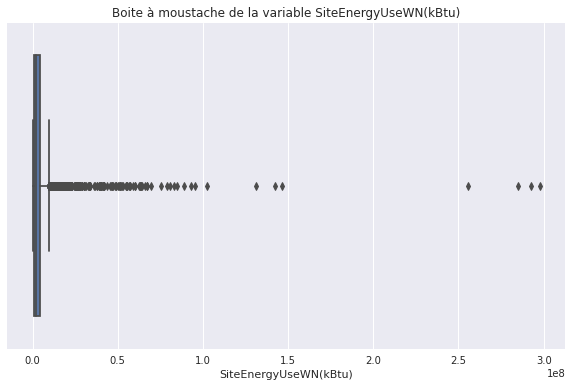

----------------------------------------------------------------------------------------------------


count    3.275000e+03
mean     5.178300e+06
std      1.380086e+07
min      0.000000e+00
25%      9.906405e+05
50%      1.972491e+06
75%      4.380328e+06
max      2.977410e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

Distribution de la variable SiteEUIWN(kBtu) en 2016


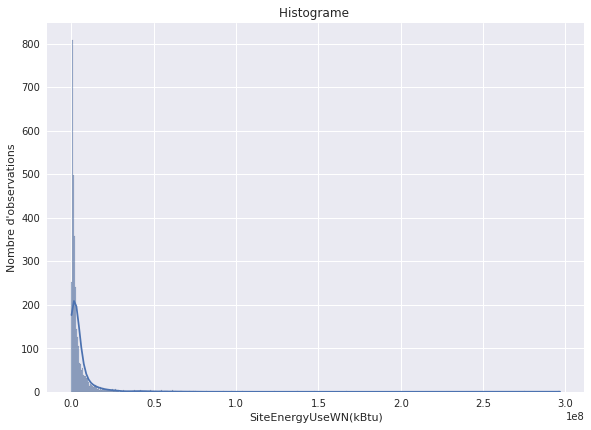

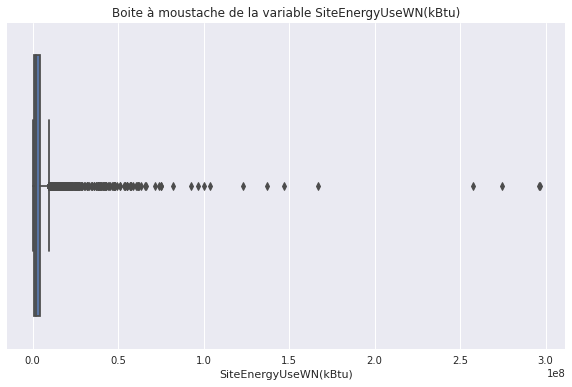

----------------------------------------------------------------------------------------------------


count    3.279000e+03
mean     5.141355e+06
std      1.390810e+07
min      0.000000e+00
25%      9.672574e+05
50%      1.891351e+06
75%      4.332010e+06
max      2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [5]:
data_2015_present_in_2016 = data_2015.loc[list(idx_2015 & idx_2016),:]
data_2016_present_in_2015 = data_2016.loc[list(idx_2015 & idx_2016),:]


def distribution_plots(data, col, bins="sturges",  hide_outliers=False):

    hist_plot = sns.displot( data=data, x=col, bins=bins, kde=True)
    hist_plot.fig.set_figwidth(9)
    hist_plot.fig.set_figheight(6)
    plt.ylabel("Nombre d'observations")
    plt.xlabel(f"{col}")
    if hide_outliers == True:
        plt.xlim(left= 0, right=(data[col].quantile(0.75) + 1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))))
    plt.title("Histograme ")
    plt.show(block=False)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax = sns.boxplot(data=data, x=col)
    ax.set_title(f"Boite à moustache de la variable {col}")
    if hide_outliers == True:
        ax.set_xlim(left=0, right=(data[col].quantile(0.75) + 1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))))
    ax.set_xlabel(f"{col}")
    plt.show(block=False)

    print("-" * 100)
    display(data[col].describe())


print("Distribution de la variable SiteEUIWN(kBtu) en 2015")
distribution_plots(data_2015_present_in_2016,"SiteEnergyUseWN(kBtu)", bins=500)
print("Distribution de la variable SiteEUIWN(kBtu) en 2016")
distribution_plots(data_2016_present_in_2015,"SiteEnergyUseWN(kBtu)", bins=500)

Sur cette varibale, malgré des fluctuations d'indicateurs, les formes de distributions restent très semblables. vérifions si c'est également le cas pour les émissions de CO2.

Distribution de la variable GHGEmissions(MetricTonsCO2e) en 2015


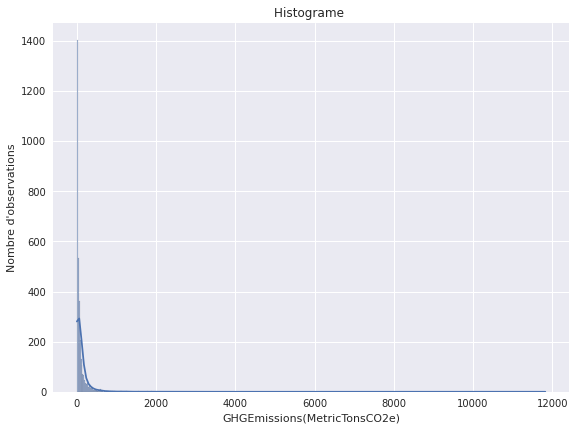

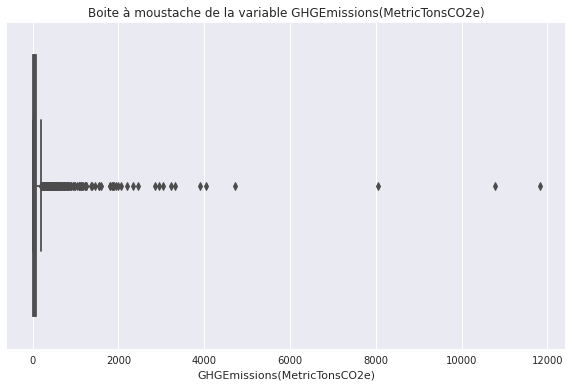

----------------------------------------------------------------------------------------------------


count     3275.000000
mean       109.080015
std        403.188409
min          0.000000
25%          9.460000
50%         32.850000
75%         88.625000
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

Distribution de la variable TotalGHGEmissions en 2016


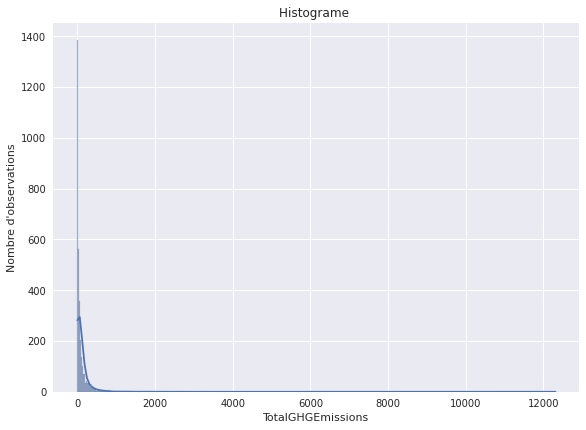

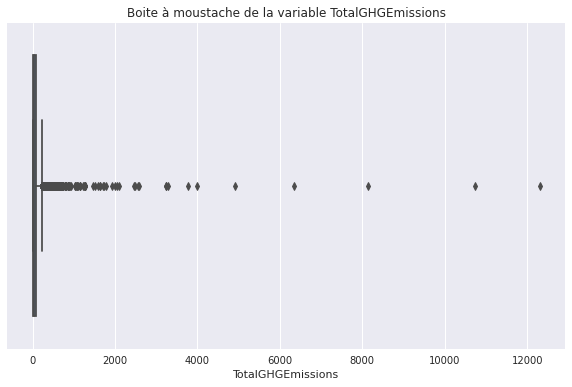

----------------------------------------------------------------------------------------------------


count     3277.000000
mean       111.273961
std        418.145545
min         -0.800000
25%          9.290000
50%         33.220000
75%         92.520000
max      12307.160000
Name: TotalGHGEmissions, dtype: float64

In [6]:
print("Distribution de la variable GHGEmissions(MetricTonsCO2e) en 2015")
distribution_plots(data_2015_present_in_2016,"GHGEmissions(MetricTonsCO2e)",bins=500)
print("Distribution de la variable TotalGHGEmissions en 2016")
distribution_plots(data_2016_present_in_2015,"TotalGHGEmissions",bins=500)

Le constat est le même que pour la consommation d'énergie. Afin de simplifier les travaux nous allons réaliser la suite exlusivement sur l'année 2015. A la fin de la validation du / des modèles de 2015, nous les testerons également sur 2016.

### Valeurs manquantes

Afin de réaliser un premier filtre nous observons le taux de complétion des variables.

In [7]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

test_completion(data_2015)

,Taux de complétion,Nombre de valeurs manquantes
DataYear,100.00,0
YearBuilt,100.00,0
ComplianceStatus,100.00,0
BuildingType,100.00,0
PropertyGFABuilding(s),100.00,0
PropertyGFAParking,100.00,0
PropertyGFATotal,100.00,0
NumberofBuildings,100.00,0
Zip Codes,100.00,0
Neighborhood,100.00,0


En croisant les résultats avec l'étude de la [nomemclature](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) des variables, nous en écartons certaines:
- "2010 Census tracts" : données de recensement de 2010
- "Seattle Police Department Micro Community Policing Plan Areas", "SPD Beats" : variables liées à l'activité policière
- "City Council Districts": numéros de districs municipaux
- "YearsENERGYSTARCertified": Années où le batiment à reçu une certification ENERGYSTAR
- "Comment": divers commentaires
- "DataYear": Année du relevé. Toutes les observations ont une valeur égale.

Ces variables ont en commun de ne pas avoir de relation avec la physique des bâtiments et / ou d'être faiblement représentées dans le dataset.

In [8]:
drop_cols = [
            "2010 Census Tracts", 
            "Seattle Police Department Micro Community Policing Plan Areas",
            "SPD Beats",
            "City Council Districts",
            "YearsENERGYSTARCertified",
            "Comment",
            "DataYear"
            ]

data_2015.drop(axis=1, columns=drop_cols, inplace=True)

pd.set_option("display.max_columns", 37)
print(f"Dimensions des données 2015 après suppresion des variables: {data_2015.shape[0]} observations {data_2015.shape[1]} variables")
print("Cinq première observation du dataset après suppression des colonnes.")
data_2015.head(5)

Dimensions des données 2015 après suppresion des variables: 3340 observations 39 variables
Cinq première observation du dataset après suppression des colonnes.


,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Outlier,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,...,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,Compliant,NaN,18081
2,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,...,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,Compliant,NaN,18081
3,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,...,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,Compliant,NaN,18081
5,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,...,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,Compliant,High Outlier,18081
8,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,...,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,Compliant,NaN,19576


### Valeurs à prédire à zéro et valeurs à pédire manquantes.

Afin de poursuivre le filtrage des observations, nous étudions celles ou les variables à prédire sont à 0 ou manquantes.

In [9]:
to_predict_zero = data_2015[(data_2015["SiteEnergyUseWN(kBtu)"] == 0) | (data_2015["GHGEmissions(MetricTonsCO2e)"] == 0)]
to_predict_na = data_2015[(data_2015["SiteEnergyUseWN(kBtu)"].isna()) | (data_2015["GHGEmissions(MetricTonsCO2e)"].isna())]
print(f"Nombre d'observations où les variables à pérédire sont à zéro: {to_predict_zero.shape[0]}\n")
display(to_predict_zero)
print(f"Nombre d'observations où les variables à pérédire sont manquantes: {to_predict_na.shape[0]}\n")
display(to_predict_na)

Nombre d'observations où les variables à pérédire sont à zéro: 12



,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Outlier,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
58,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1975700365,"{'latitude': '47.61076355', 'longitude': '-122...",7,DOWNTOWN,1920,1,2.0,57428,0,57428,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,34617.0,Non-Refrigerated Warehouse,13028.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,No,Compliant,NaN,18081
328,NonResidential,Large Office,CENTURYLINK: SEATTLE BELL PLAZA,659000165,"{'latitude': '47.61323929', 'longitude': '-122...",7,DOWNTOWN,1976,1,33.0,791396,0,791396,"Office, Other, Parking, Restaurant",Office,637099.0,Parking,132465.0,...,59.8,0.0,187.7,0.0,40451748.0,0.0,0.0,11855730.0,40453430.0,0.0,0.0,0.0,282.01,0.14,No,Compliant,NaN,18081
609,NonResidential,Small- and Mid-Sized Office,HERITAGE BUILDING,5247800255,"{'latitude': '47.59894829', 'longitude': '-122...",2,DOWNTOWN,1904,1,5.0,78920,0,78920,Office,Office,65600.0,NaN,NaN,...,30.4,0.0,95.0,0.0,1992690.0,0.0,0.0,580321.0,1980139.0,0.0,0.0,12551.0,13.80,0.07,No,Compliant,NaN,18379
659,NonResidential,Large Office,RUSSELL INVESTMENTS CENTER,9184500000,"{'latitude': '47.60761629', 'longitude': '-122...",7,DOWNTOWN,2005,1,42.0,1592914,297457,1295457,"Data Center, Financial Office, Office, Parking...",Office,914832.0,Parking,348788.0,...,46.5,0.0,143.6,0.0,58041572.0,0.0,1099052.0,16567390.0,56530281.0,4146.0,414587.0,0.0,500.93,0.16,No,Compliant,NaN,18081
765,NonResidential,Large Office,SEATTLE TOWER,1975200005,"{'latitude': '47.60765462', 'longitude': '-122...",7,DOWNTOWN,1929,1,27.0,216571,13320,203251,"Office, Other - Technology/Science, Parking",Office,182604.0,Parking,13320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,No,Compliant,NaN,18081
772,NonResidential,Large Office,BANK OF AMERICA FIFTH AVENUE PLAZA,942000470,"{'latitude': '47.60600047', 'longitude': '-122...",3,DOWNTOWN,1981,1,42.0,1249055,201121,1047934,"Data Center, Medical Office, Office, Parking, ...",Office,983697.0,Parking,296815.0,...,42.0,0.0,127.7,0.0,41818868.0,0.0,0.0,11686460.0,39875857.0,0.0,0.0,1943011.0,277.98,0.09,No,Compliant,NaN,18379
814,NonResidential,Large Office,WEST LAKE UNION CENTER- 1501 WESTLAKE,8807900130,"{'latitude': '47.63266558', 'longitude': '-122...",7,MAGNOLIA / QUEEN ANNE,1994,1,10.0,381511,0,381511,"Office, Parking",Office,220033.0,Parking,168978.0,...,53.7,0.0,163.8,0.0,11813861.0,0.0,0.0,3316016.0,11314716.0,4996.0,499616.0,0.0,105.41,0.15,No,Compliant,NaN,18390
20130,NonResidential,Worship Facility,GREEN LAKE UNITED METHODIST,1257200735,"{'latitude': '47.67572194', 'longitude': '-122...",6,NORTHWEST,1910,1,2.0,23931,0,23931,Worship Facility,Worship Facility,23931.0,NaN,NaN,...,18.8,0.0,33.5,0.0,450518.0,0.0,0.0,46215.0,157691.0,2928.0,292834.0,0.0,16.65,0.67,No,Compliant,NaN,18377
20324,NonResidential,Worship Facility,TEMPLE BETH AM,1513800009,"{'latitude': '47.68762613', 'longitude': '-122...",4,NORTHEAST,2000,1,2.0,31386,0,31386,Worship Facility,Worship Facility,30000.0,NaN,NaN,...,32.6,0.0,82.9,0.0,978211.0,0.0,0.0,204897.0,699137.0,2791.0,279103.0,0.0,19.70,0.53,No,Compliant,NaN,18792


Nombre d'observations où les variables à pérédire sont manquantes: 10



,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Outlier,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87,SPS-District K-12,K-12 School,ARBOR HEIGHTS ELEMENTARY SCHOOL (SPS-DISTRICT),2518400005,"{'latitude': '47.50935392', 'longitude': '-122...",1,SOUTHWEST,1948,1,2.0,53352,0,53352,K-12 School,K-12 School,53352.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Compliant,Low Outlier,17920
19694,SPS-District K-12,K-12 School,MANN (SPS-DISTRICT),519000290,"{'latitude': '47.60818545', 'longitude': '-122...",3,CENTRAL,1925,1,2.0,37327,0,37327,K-12 School,K-12 School,41191.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Compliant,NaN,19578
19798,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,225049032,"{'latitude': '47.68152686', 'longitude': '-122...",4,NORTHEAST,1977,1,3.0,33166,0,33166,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Not Compliant,NaN,18792
21548,Multifamily LR (1-4),Low-Rise Multifamily,PUGET VISTA APTS,1992200030,"{'latitude': '47.62305186', 'longitude': '-122...",7,MAGNOLIA / QUEEN ANNE,1967,1,4.0,40086,6133,33953,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Not Compliant,NaN,19575
21570,SPS-District K-12,K-12 School,PINEHURST ELEMENTARY (SPS-DISTRICT),2044500390,"{'latitude': '47.71334315', 'longitude': '-122...",5,NORTH,1950,1,1.0,34005,0,34005,K-12 School,K-12 School,34005.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Compliant,NaN,19579
21578,SPS-District K-12,K-12 School,GENESEE SCHOOL (SPS-DISTRICT),2095200005,"{'latitude': '47.56546417', 'longitude': '-122...",1,SOUTHWEST,1949,1,1.0,41221,0,41221,K-12 School,K-12 School,41221.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Compliant,Low Outlier,18795
23508,Multifamily LR (1-4),Low-Rise Multifamily,SEAVIEW CONDOMINIUM,7677290000,"{'latitude': '47.62560764', 'longitude': '-122...",7,MAGNOLIA / QUEEN ANNE,1930,1,3.0,53040,0,53040,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Not Compliant,NaN,19575
24408,SPS-District K-12,K-12 School,WILSON-PACIFIC (SPS-DISTRICT),3126049064,"{'latitude': '47.69548916', 'longitude': '-122...",5,NORTHWEST,1953,1,1.0,110830,0,110830,K-12 School,K-12 School,110830.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Compliant,NaN,18377
25361,SPS-District K-12,K-12 School,DECATUR ELEMENTARY (SPS-DISTRICT),6392002430,"{'latitude': '47.68558967', 'longitude': '-122...",4,NORTHEAST,1961,1,1.0,43578,0,43578,K-12 School,K-12 School,45370.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Compliant,NaN,18792


Le nombre étant restraint, nous décidons de les supprimer.

In [10]:
idx_zero = set(to_predict_zero.index)
idx_na = set(to_predict_na.index)
idx_to_drop = idx_zero | idx_na
data_2015.drop(axis = 0, index=idx_to_drop, inplace = True)
print(f"Nombre d'observations restantes: {data_2015.shape[0]}")

Nombre d'observations restantes: 3318


### Valeurs aberrantes

#### Etude de la variable Outlier

Dans les données une variable est explicitement désignée comme "Outlier". Regardons les différentes modalités que peut prendre la variable.

In [11]:
data_2015["Outlier"].unique()

array([nan, 'High Outlier', 'Low Outlier'], dtype=object)

Vraissemblalement la varibale qualifie les valeurs aberrantes selon qu'elles soient hautes ou basses. Les observations où la variable n'est pas renseignée corresponderaient aux observations qui n'ont pas été considérées comme aberrantes lors des relevés. Regradons les populations pour chaques modalité.

In [12]:
num_hight_outliers = data_2015[data_2015["Outlier"] == "High Outlier"]
num_low_outliers = data_2015[data_2015["Outlier"] == "Low Outlier"]
num_non_outliers = data_2015[data_2015["Outlier"].isna()]

print(f"Nombre d'observations aberrantes hautes: {num_hight_outliers.shape[0]}")
print(f"Nombre d'observations aberrantes hautes: {num_low_outliers.shape[0]}")
print(f"Nombre d'observations non aberrantes: {num_non_outliers.shape[0]}\n")

Nombre d'observations aberrantes hautes: 46
Nombre d'observations aberrantes hautes: 36
Nombre d'observations non aberrantes: 3236



Nous supprimons l'ensemble des observations considérées comme aberrantes. Après celà nous supprimons aussi la variable qui n'a plus d'intérêt après le filtrage.

In [13]:
all_outliers = set(num_hight_outliers.index) | set(num_low_outliers.index)
data_2015.drop(index= all_outliers, columns="Outlier", inplace=True)
print(f"Nombre d'observations restantes: {data_2015.shape[0]}")

Nombre d'observations restantes: 3236


#### Observations où la surface l'activité principale est supérieure à la surface totale

Certains observations ont une valeur variable LargestPropertyUseTypeGFA supérieure à celle de la variable PropertyGFATotal. Observons le phénomène.

In [14]:
cols = [
        "YearBuilt",
        "LargestPropertyUseType",
        "SecondLargestPropertyUseType",
        "ThirdLargestPropertyUseType",
        "NumberofBuildings",
        "NumberofFloors",
        "PropertyGFATotal", 
        "PropertyGFAParking", 
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        "SecondLargestPropertyUseTypeGFA",
        "ThirdLargestPropertyUseTypeGFA",
        "SiteEUIWN(kBtu/sf)",
        "GHGEmissionsIntensity(kgCO2e/ft2)"             
]
possible_outliers = data_2015[data_2015["LargestPropertyUseTypeGFA"] > data_2015["PropertyGFATotal"]].loc[:,cols]
print("10 premières observations où la surface de l'activité principale est supérieure à la surface totale du bâtiment")
display(possible_outliers.head(10))
print(f"Nombre d'observations où la surface d'activité principale est supérieure à la surface totale: {possible_outliers.shape[0]}")

10 premières observations où la surface de l'activité principale est supérieure à la surface totale du bâtiment


,YearBuilt,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),GHGEmissionsIntensity(kgCO2e/ft2)
OSEBuildingID,,,,,,,,,,,,,,
8,1980,Hotel,Parking,Swimming Pool,1,18.0,119890,12460,107430,123445.0,68009.0,0.0,122.1,4.02
16,1998,Hotel,NaN,NaN,1,25.0,333176,61161,272015,336640.0,NaN,NaN,83.1,1.93
28,1961,K-12 School,NaN,NaN,1,2.0,56228,0,56228,58320.0,NaN,NaN,29.6,0.56
36,1949,K-12 School,NaN,NaN,1,2.0,160645,0,160645,164229.0,NaN,NaN,50.9,1.58
37,1989,K-12 School,NaN,NaN,1,2.0,51582,0,51582,55166.0,NaN,NaN,30.5,0.08
51,1950,K-12 School,NaN,NaN,1,2.0,175565,0,175565,182861.0,NaN,NaN,45.5,1.44
56,1969,Hotel,NaN,NaN,1,24.0,332210,205970,126240,348630.0,NaN,NaN,44.9,0.63
84,1922,Senior Care Community,Parking,NaN,1,5.0,217603,0,217603,296313.0,0.0,NaN,170.9,8.30
98,1929,Retail Store,NaN,NaN,1,2.0,58320,0,58320,72072.0,NaN,NaN,19.2,0.65


Nombre d'observations où la surface d'activité principale est supérieure à la surface totale: 298


Globalement sur ces observation la surface de l'activité principale est significativement supérieur à la surface totale. A défaut de pouvoir trouver une explication dans les autres variable, nous décidons de supprimer ces observations.

In [15]:
data_2015.drop(index=possible_outliers.index, inplace=True)
print(f"Observations restantes: {data_2015.shape[0]}")

Observations restantes: 2938


#### Observation ayant une surface de parking négative

Ceratines observations ont une valeur de variable PropertyGFAParking négative. Observons le phénomène.

In [16]:
negative_parking_outliers = data_2015[data_2015["PropertyGFAParking"]<0]
negative_parking_outliers

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25530,Multifamily MR (5-9),Mid-Rise Multifamily,WATER'S EDGE,9197580000,"{'latitude': '47.52056437', 'longitude': '-122...",2,SOUTHEAST,1964,1,5.0,20967,-3,20970,Multifamily Housing,Multifamily Housing,20967.0,NaN,NaN,...,81.0,25.7,27.5,80.8,86.4,539271.0,576638.0,0.0,158051.0,539293.0,0.0,0.0,0.0,3.76,0.07,No,Compliant,18800
29551,NonResidential,Small- and Mid-Sized Office,625 5TH AVE S,8809700040,"{'latitude': '47.59725206', 'longitude': '-122...",2,DOWNTOWN,2000,1,11.0,68452,-2,68454,"Bank Branch, Office",Office,61665.0,Bank Branch,6787.0,...,81.0,53.6,58.3,168.4,182.9,3670298.0,3988260.0,0.0,1075703.0,3670451.0,0.0,0.0,0.0,25.59,0.14,No,Compliant,18379


Nous décisons de supprimer ces observations.

In [18]:
data_2015.drop(index=negative_parking_outliers.index, inplace=True)
print(f"Nombre d'observations restante: {data_2015.shape[0]}")

Nombre d'observations restante: 2936


#### Observations où l'énergie totale consommée est inférieur à la somme totale des types énergies consommées


Observons ces valeurs.

In [19]:
energy_outliers = data_2015[(data_2015["SteamUse(kBtu)"]+data_2015["Electricity(kBtu)"]+data_2015["NaturalGas(kBtu)"]+data_2015["OtherFuelUse(kBtu)"])<data_2015["SiteEnergyUse(kBtu)"]]
energy_outliers

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21436,Nonresidential COS,Other,SEATTLE CHILDREN'S THEATER - SEATTLE CENTER,1985200550,"{'latitude': '47.6219494', 'longitude': '-122....",7,MAGNOLIA / QUEEN ANNE,1992,1,2.0,40600,0,40600,Other,Other,33000.0,NaN,NaN,...,NaN,74.7,75.7,172.9,174.5,2464720.0,2497369.0,232000.0,435377.0,1485569.0,3192.0,319212.0,427938.0,45.22,0.96,No,Compliant,18390
25004,Multifamily LR (1-4),Low-Rise Multifamily,PENN HALL APTS,3667500025,"{'latitude': '47.61946682', 'longitude': '-122...",3,CENTRAL,1926,1,3.0,27840,7031,20809,"Multifamily Housing, Parking",Multifamily Housing,20809.0,Parking,7031.0,...,99.0,35.1,35.9,69.0,69.9,730292.0,748040.0,0.0,94518.0,322509.0,2646.0,264648.0,143134.0,16.30,0.54,No,Compliant,18789


Leur nombre étant faible, nous les supprimons.

In [20]:
data_2015.drop(index=energy_outliers.index, inplace=True)
print(f"Nombre de valeurs restantes: {data_2015.shape[0]}")

Nombre de valeurs restantes: 2934


#### Observation où le nombre d'étages est aberrant

Lors de l'exploration des données nous avons pu constater des valeurs potentiellement abérantes sur la variable NumberofFloors. Afin vérifier l'hypothèse nous réalisons un digramme tige-feuilles.

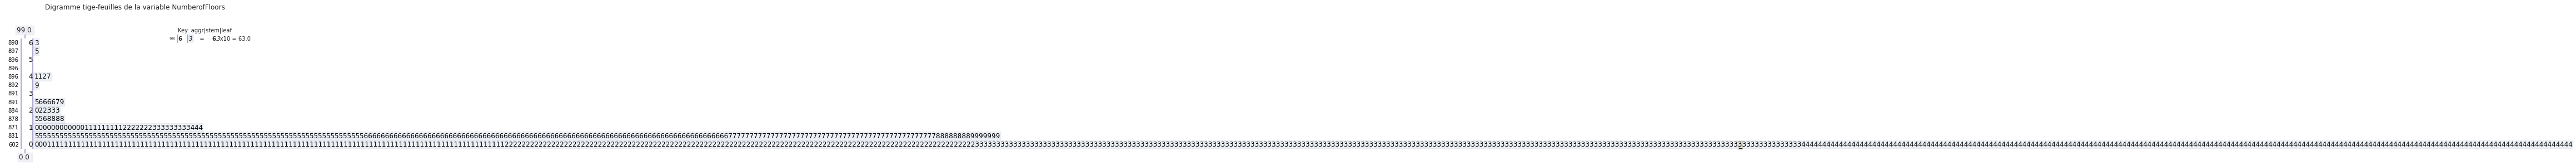

In [21]:
import stemgraphic
fig, ax = stemgraphic.stem_graphic(data_2015["NumberofFloors"])
plt.title("Digramme tige-feuilles de la variable NumberofFloors")
plt.show()

On observe un etallement des données à partire de la valeur 47. Visualisons les données qui ont des valeur égales ou supérieures à ce seuil.

In [22]:
display(data_2015[data_2015["NumberofFloors"]>=47].sort_values("NumberofFloors", ascending=False))
print(f"Medianne de la variable PopertyGFATotal: {data_2015['PropertyGFATotal'].median()}")
print(f"Medianne de la variable SiteEnergyUseWN(kBtu): {data_2015['SiteEnergyUseWN(kBtu)'].median()}")
print(f"Medianne de la variable GHGEmissions(MetricTonsCO2e): {data_2015['GHGEmissions(MetricTonsCO2e)'].median()}")

,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21611,NonResidential,Worship Facility,CHINESE BAPTIST CHURCH,2124049098,"{'latitude': '47.55057128', 'longitude': '-122...",2,GREATER DUWAMISH,1977,1,99.0,21948,0,21948,Worship Facility,Worship Facility,21948.0,NaN,NaN,...,54.0,14.5,14.5,45.5,45.5,318205.0,318205.0,0.0,93261.0,318218.0,0.0,0.0,0.0,2.22,0.04,Yes,Compliant,18388
775,NonResidential,Large Office,COLUMBIA CENTER,942000640,"{'latitude': '47.60466039', 'longitude': '-122...",7,DOWNTOWN,1985,1,76.0,1952220,319400,1632820,"Office, Parking",Office,1680937.0,Parking,319368.0,...,84.0,56.3,55.5,171.9,169.1,94560088.0,93255440.0,0.0,26597630.0,90754881.0,38090.0,3808965.0,0.0,834.96,0.23,No,Compliant,18379
357,Nonresidential COS,Large Office,SEATTLE MUNICIPAL TOWER,942000720,"{'latitude': '47.60491077', 'longitude': '-122...",3,DOWNTOWN,1990,1,63.0,1195387,159600,1035787,"Office, Other, Parking",Office,1187924.0,Parking,159599.0,...,82.0,53.6,54.6,168.4,171.3,64715652.0,65842744.0,0.0,18960680.0,64696526.0,218.0,21804.0,0.0,452.16,0.15,No,Compliant,18379
422,NonResidential,Large Office,TWO UNION SQUARE,1976700125,"{'latitude': '47.61001362', 'longitude': '-122...",7,DOWNTOWN,1989,1,56.0,1605578,389860,1215718,"Office, Other, Parking",Office,1314475.0,Parking,389860.0,...,97.0,35.9,37.1,108.0,111.8,48342560.0,49973408.0,595133.0,13243190.0,45187640.0,25617.0,2561662.0,0.0,496.99,0.19,No,Compliant,18081
399,NonResidential,Large Office,WASH MUTUAL TOWER (1201 THIRD AVE),1974700120,"{'latitude': '47.60722258', 'longitude': '-122...",7,DOWNTOWN,1988,1,55.0,1400000,285000,1115000,"Office, Other, Parking, Restaurant",Office,1021940.0,Parking,264481.0,...,94.0,44.7,47.5,134.2,142.0,51625548.0,54830920.0,1923581.0,14092650.0,48086118.0,16178.0,1617830.0,0.0,569.61,0.26,No,Compliant,18081
353,NonResidential,Large Office,SAFECO PLAZA / 1001 FOURTH AVENUE,942000300,"{'latitude': '47.60633748', 'longitude': '-122...",7,DOWNTOWN,1969,1,49.0,1123435,368980,754455,"Financial Office, Food Sales, Office, Other, P...",Office,808980.0,Parking,232248.0,...,88.0,55.0,59.6,152.9,161.1,47148456.0,51103256.0,0.0,11429570.0,38999312.0,81508.0,8150777.0,0.0,704.76,0.48,No,Compliant,17923
345,NonResidential,Large Office,999 THIRD AVE,939000435,"{'latitude': '47.60523404', 'longitude': '-122...",7,DOWNTOWN,1983,1,47.0,1323055,0,1323055,"Office, Parking, Restaurant",Office,1011135.0,Parking,272682.0,...,93.0,43.0,45.1,134.6,141.3,45074876.0,47306916.0,0.0,13163170.0,44914600.0,1621.0,162130.0,0.0,321.72,0.10,No,Compliant,18379


Medianne de la variable PopertyGFATotal: 43629.5
Medianne de la variable SiteEnergyUseWN(kBtu): 1866646.0
Medianne de la variable GHGEmissions(MetricTonsCO2e): 30.19


Nous constatons que l'observation avec 99 étage a une surface et des indicateurs de consommation d'énergie et d'émission de CO2 très inférieurs à la médiane de ces variables. On peut en déduire que l'observation est aberrrante. 
Les autres observations ont des valeurs bien supérieures aux médianes observées. Nous ne pouvons donc pas la considérer comme aberrante.

In [23]:
data_2015.drop(index=21611, inplace=True)
print(f"Nombre d'observations restantes: {data_2015.shape[0]}")

Nombre d'observations restantes: 2933


### Filtrage des variables explicatives fortement corrélées entre elles

Nous commençons par observer largement la distribution de toutes les variable quantitatives restantes.

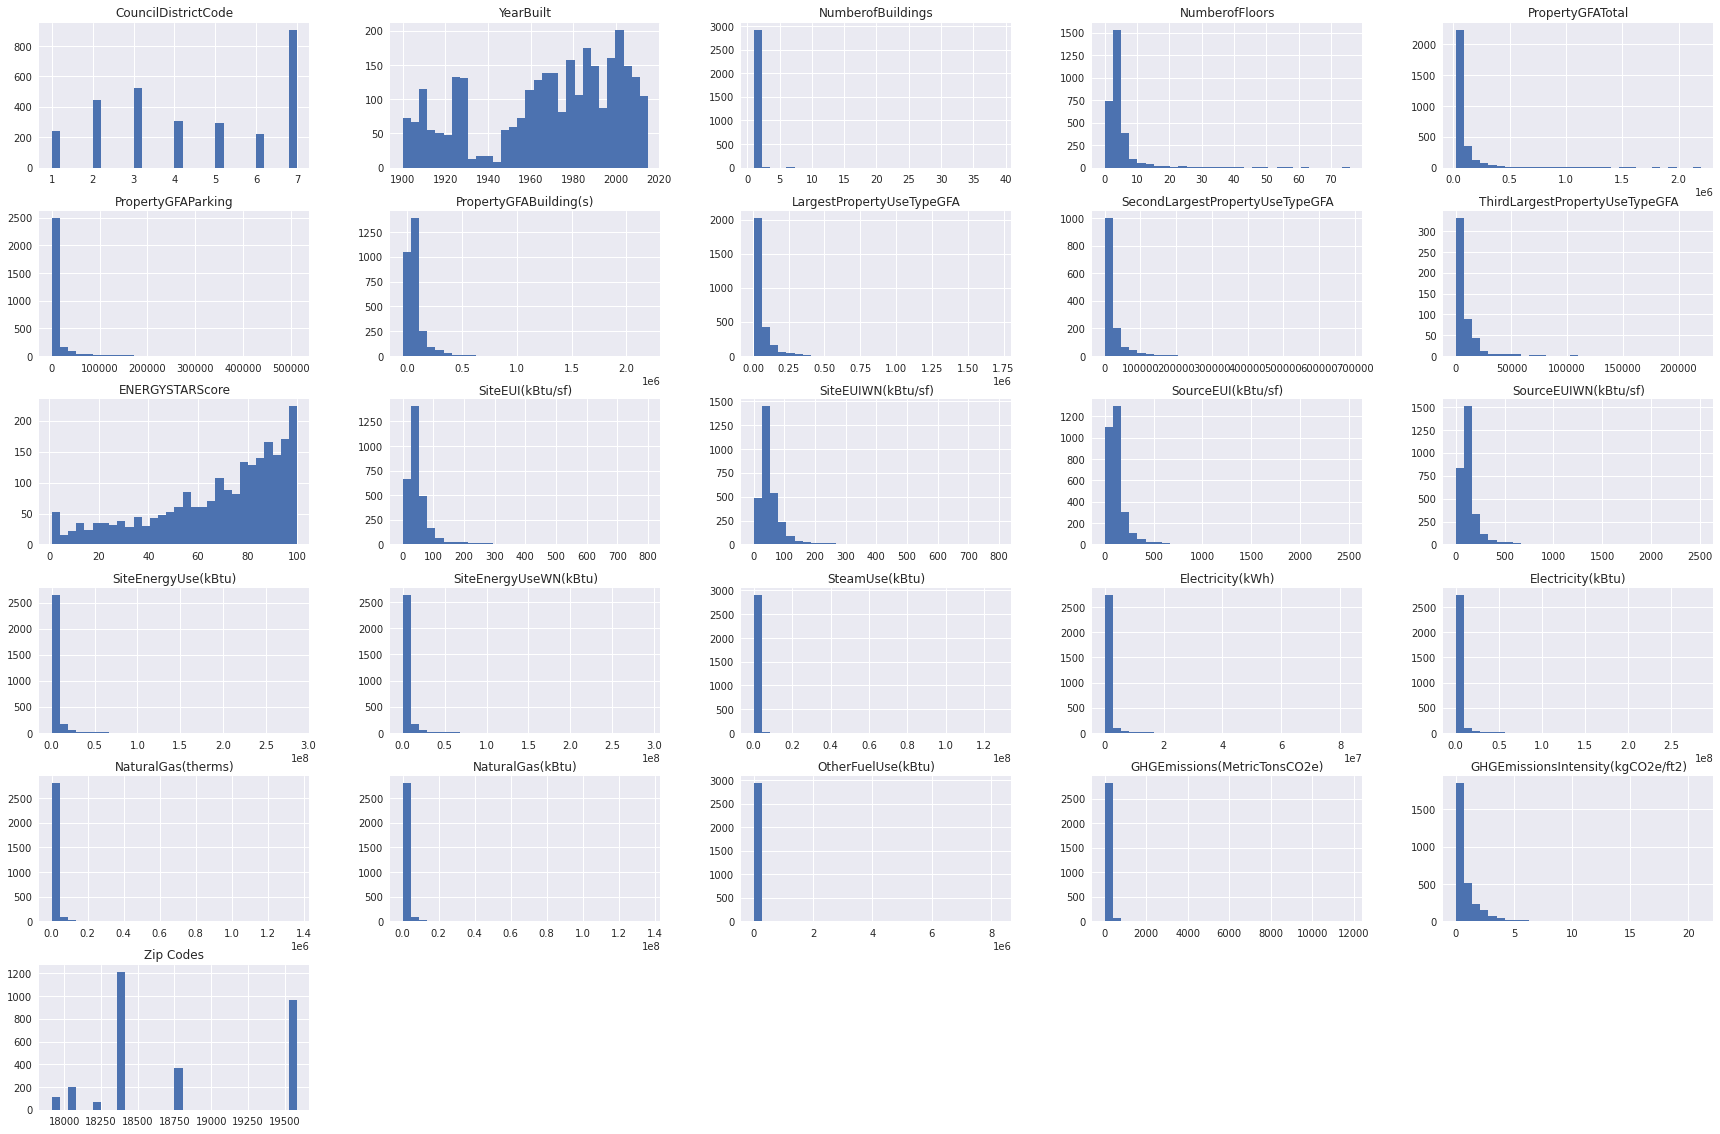

In [24]:
data_2015.hist(bins=30, figsize=(30, 20))
plt.show()

Nous pouvons dors et déjà faire plusieurs constats:

 - Certaines variables semblent avoir une modalité majoritaire comme NumberofBuildings
 
 - Une majorité de varibale semble avoir une distribution concentrée autour des valeurs faibles. Parmi celles-ci:
     - Les varibales de surface des sites (incluant GFA)
     - Les variables de consommation des sites


- Plusieurs séries de variables semblent avoir des comportement de distribution proches. Parmi celles-ci:
    - Les variables sur les surfaces. A noter que  la variable PropertyGFABuilding(s) semble avoir un comportement sensiblement différent sur les valeurs basses
    - Les couples de varibales brutes et normalisées par la météo des données de consommations par site (ccontenant SiteEUI ou SiteEnergyUse)

Observons les corrélations entre les variables.

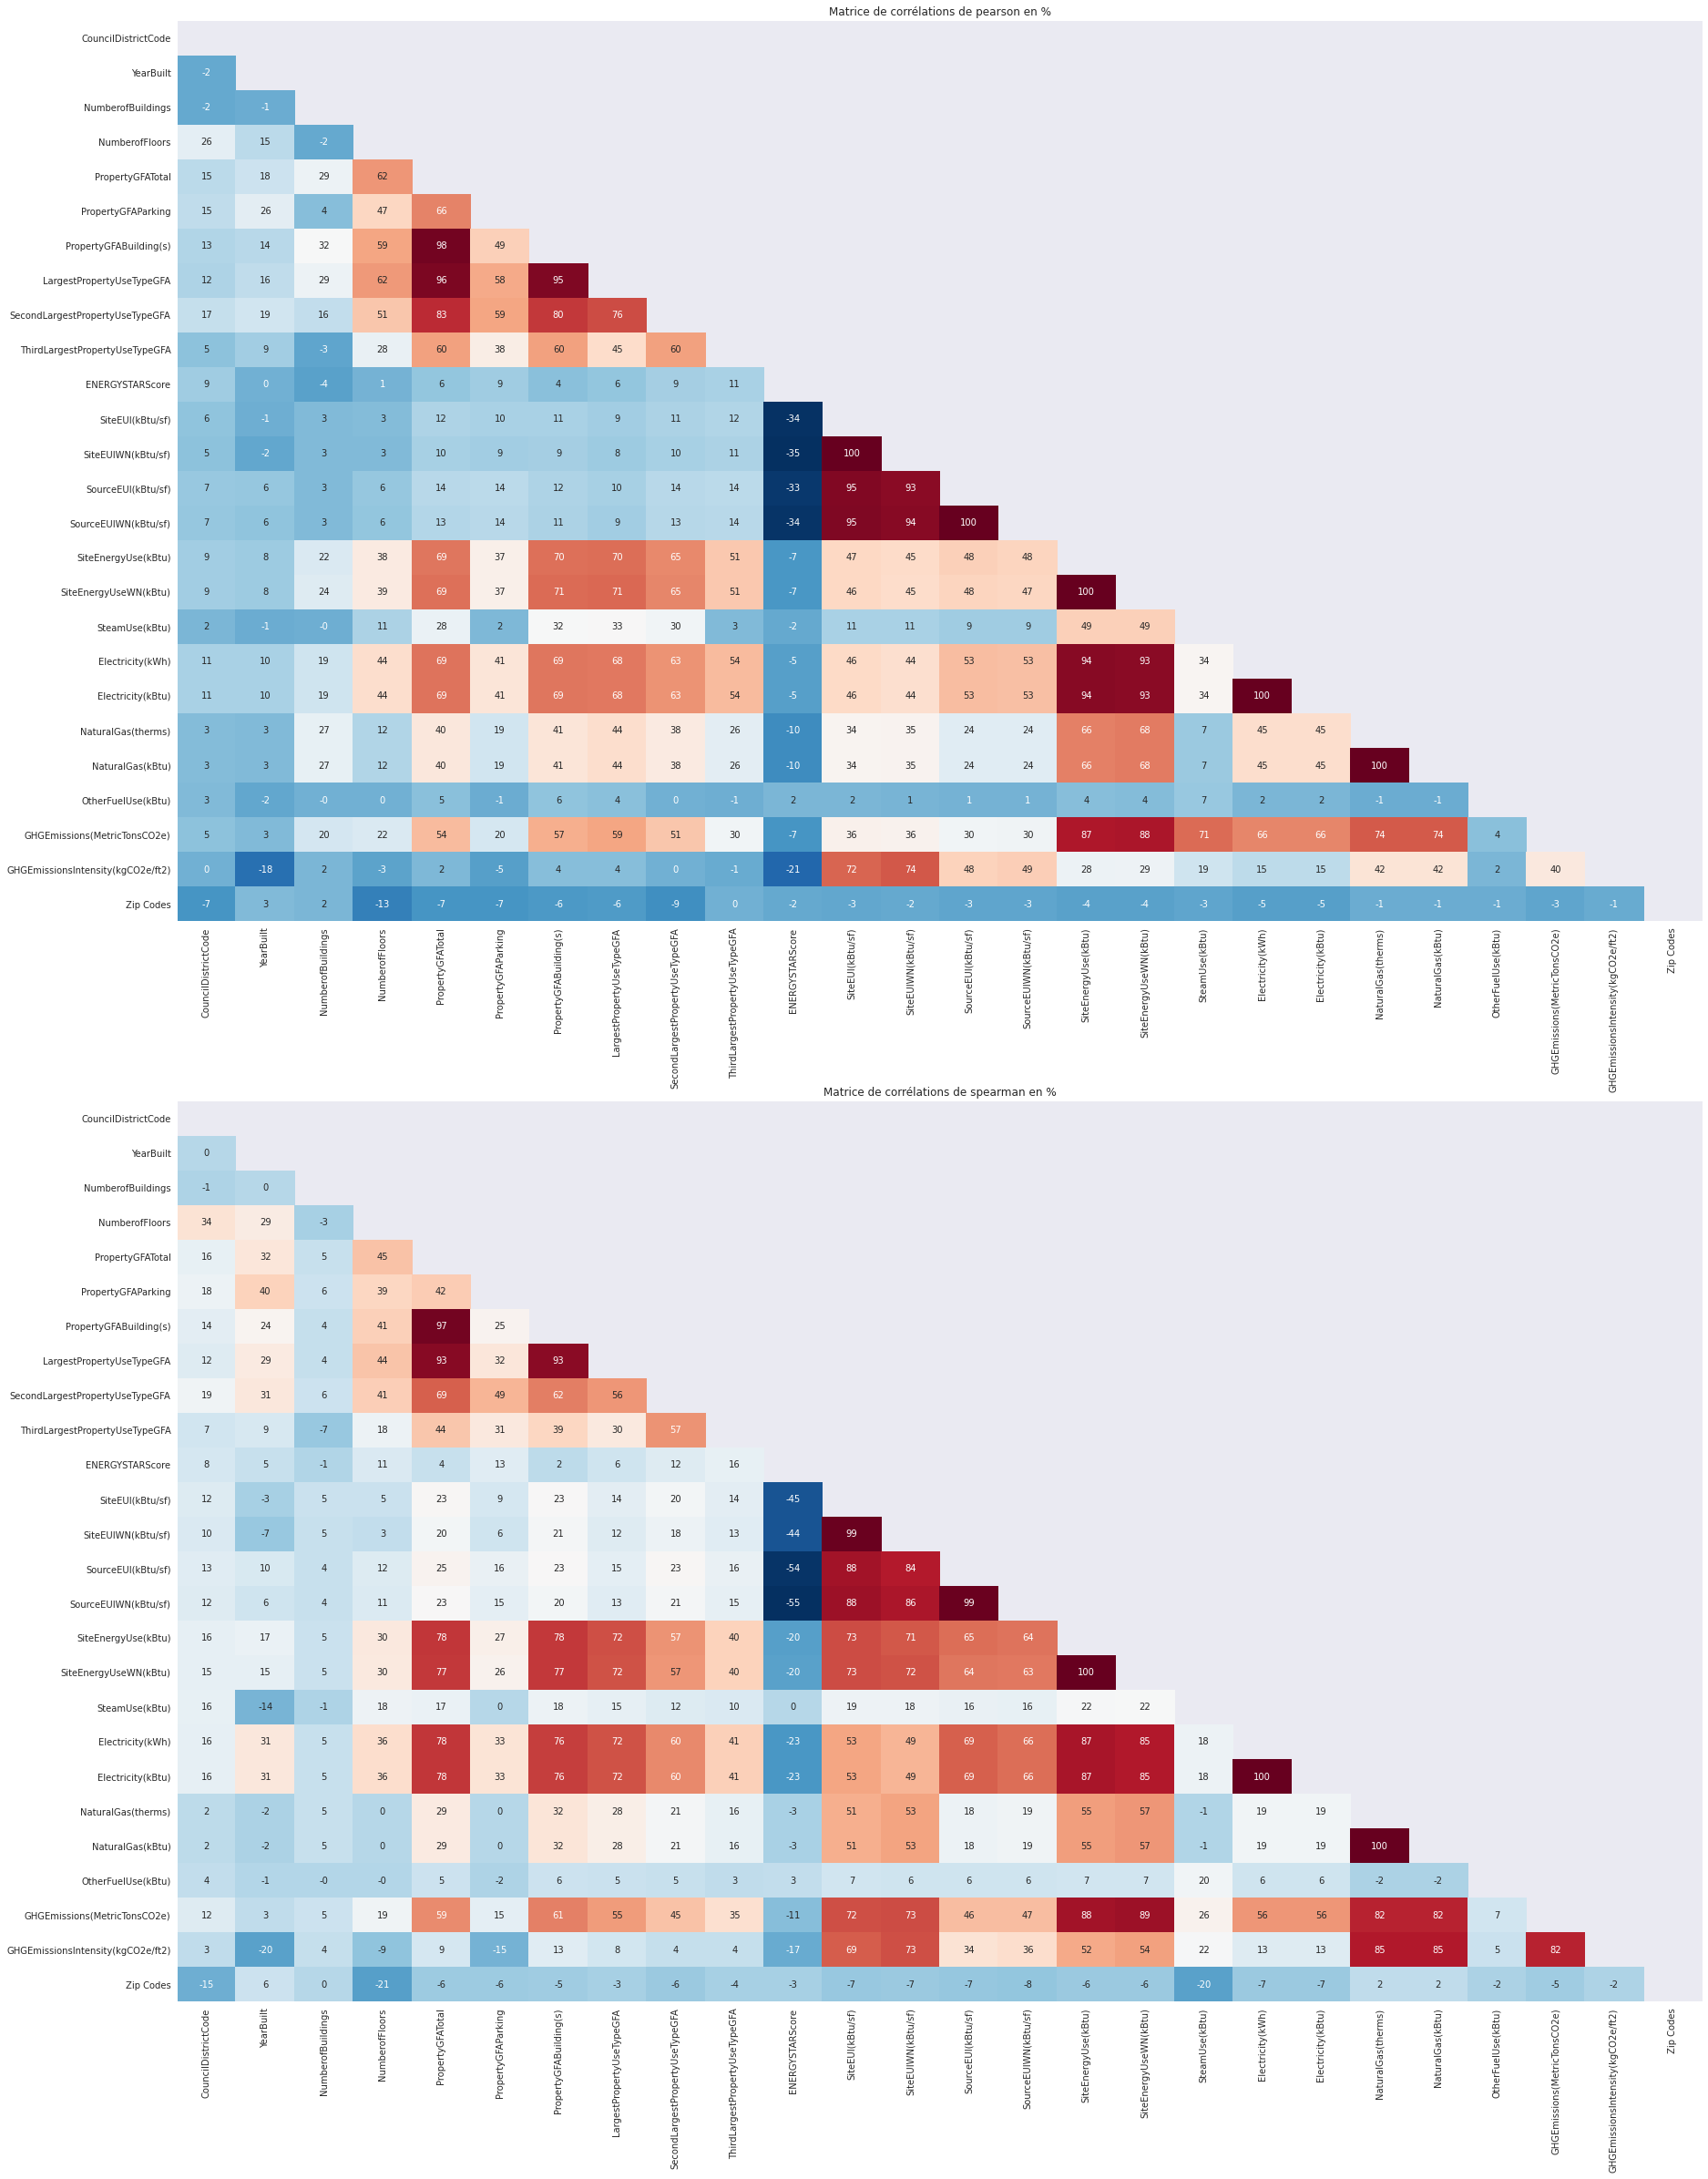

In [25]:
def correlations(data, methods):
    """
    Plot correlation matrix for quantitatives values.
    
    Args:
        data(dataframe): A dataframe
        
        method(string): CHosen method to compute correlation. Might be "pearson", "spearman" or "kendall"
        
    Returns:
        Correlation matrix
    """
    
    correlations = []
    cleanning_masks = []
    for method in methods: 
        correlation = data.select_dtypes(include=['int64','float64']).corr(method=method) * 100
        cleanning_mask = np.zeros_like(correlation)
        upper_triangle = np.triu_indices_from(correlation)
        cleanning_mask[upper_triangle] = 1
        correlations.append(correlation)
        cleanning_masks.append(cleanning_mask)

        
    fig, axes = plt.subplots(nrows=len(methods), figsize=(30,40))
    fig.subplots_adjust(wspace=0.2)

    for i in range(len(axes)):
        sns.heatmap(correlations[i], ax=axes[i], cmap="RdBu_r", mask = cleanning_masks[i], 
                   annot = True, fmt=".0f", cbar=False)

        axes[i].set_title(f"Matrice de corrélations de {methods[i]} en %")
  
    
correlations(data_2015, methods=["pearson", "spearman"])

Sur ces matrices de corrélations observons tout d'abord les corrélations entre une varibale explicatives et les deux variables à prédire:

Pour la consommation d'énergie (SiteEnergyUseWN(kBtu)), les corrélations les liaisons les plus fortes sont avec les variables de surfaces, les mesures d'énergie ramenées à une unitée de surface, les différents consommations d'énergie par type et les émissions de CO2. A noter que la consommation électrique a une corrélation plus forte que les autres types d'énergies. 

Pour les émissions de CO2, les liaisons existent avec les même variables explicatives. A noter que si la corrélation linéraire est plus forte avec l'électricité, la corréation de rang est plus forte avec la consommation de Gaz naturel.

Sans surprises sur les varibales explicatives, les corrélations sont positivement très fortes entre les consommations énergétiques, leur version normalisée et ces mêmes indicateurs ramenés à une unité de surface. 

Afin de minimiser les corrélations entre variables explicatives, nous supprimerons les indicateurs de consommation d'énergie non normalisés et ceux ramenés à une unité de surface. 

Nous constatons également que la consommation de gaz naturel est décliné en deux unités de mesures sur deux variables: NaturalGas(therms) et NaturalGaz(kBtu). Les autres énergies étant également mesurées en kBtus nous supprimons la variable NaturalGas(therms).


A noter que la variable ENERGYSTARScore a des correlations négatives faibles avec les deux variables à prédire et des corrélations négatives moyennes avec les varibales de consommation d'énergie ramenées à l'unité de surface. Utiliser cette variable pour les prédictions semble faible à ce stade. Nous vérifierons cette hypothèse lors de l'entrainement des modèles

In [26]:
drop_cols = [
             "PropertyGFABuilding(s)",
             "SiteEUI(kBtu/sf)",
             "SiteEUIWN(kBtu/sf)",
             "SourceEUI(kBtu/sf)",
             "SourceEUIWN(kBtu/sf)",
             "NaturalGas(therms)",
             "GHGEmissionsIntensity(kgCO2e/ft2)",
            ] 


filtered_data = data_2015.drop(columns = drop_cols)
print(f"Nombre de variables restantes {filtered_data.shape[1]}")

Nombre de variables restantes 31


### Filtrage des variables géographiques

Dans les variables concervées, cinq renvoient à la position géographique des bâtiments:

- TaxParcelIdentificationNumber : numéro de parcelles enregistrés dans le cadastre
- Location: Couple latitude / longitude
- CouncilDistrictCode : Numéro de district
- Neighborhood : Quartier
- Zip Code : En théorie le code postal. 

A priori l'emplacement géographique, dans le cas où nous utilisons une variable de consommation d'énergie normalisée, devraient avoir peu d'impact, sur la physique des bâtiments. Néanmoins, nous réalisons l'étude de ces variables afin de voir s'il est possible d'en conserver une
    
Nous attirons l'attention sur le fait que les valeurs présentes dans ce jeu de données, pour la variable Zip Code ne correspondent pas aux codes postaux observés généralement dans la région de Seattle. De plus les valeurs présentes dans ce jeu de données ne correspondent pas non plus à celes présentes dans le jeu de données de 2016. De ce fait nous pouvons dors et déjà éliminer cette varibale quantidate. 

Pour départager les variables candidates restantes observons le nomnbre de leurs modalités. 

In [27]:
print(f"Nombre total d'observations: {filtered_data.shape[0]}")
print(f"Nombre de modalités de la variable TaxParcelIdentificationNumber: {filtered_data['TaxParcelIdentificationNumber'].nunique()} ")
print(f"Nombre de modalités de la variable Location: {filtered_data['Location'].nunique()} ")
print(f"Nombre de modalités de la variable CouncilDistrictCode: {filtered_data['CouncilDistrictCode'].nunique()} ")
print(f"Nombre de modalités de la variable Neighborhood: {filtered_data['Neighborhood'].nunique()} ")

Nombre total d'observations: 2933
Nombre de modalités de la variable TaxParcelIdentificationNumber: 2867 
Nombre de modalités de la variable Location: 2906 
Nombre de modalités de la variable CouncilDistrictCode: 7 
Nombre de modalités de la variable Neighborhood: 13 


Nous constatons que le nombre de modalités des variables TaxParcelIdentificationNumber et Location est beaucoup trop proche du nombre d'observations afin de pouvoir carractériser une potentielle liaison entre les modalités de ces variables et les variables à prédire. 

Les deux variables restantes (CouncilDistrictCode et Neighborhood) ont un un nombre de modalités dans un même ordre de grandeur. A ce stage, Nous choisissons de garder la varibale Neighboorhood. Nous étudierons sont comportement avec les variables à prédire.

In [28]:
drop_geographic_cols = ["TaxParcelIdentificationNumber",
                       "Location",
                       "CouncilDistrictCode",
                       "Zip Codes"]

filtered_data.drop(columns=drop_geographic_cols, inplace=True)
print(f"Nombre de variables restantes: {filtered_data.shape[1]}")

Nombre de variables restantes: 27


### Varibales ComplianceStatus et DefaultData

Les deux variables ComplianceStatus et DefaultData ne sont pas détaillées dans la [nomenclature](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) des données. 
Afin de vérifier si nous les concervons, nous regardons le nombre d'observations par modalité et la distribution des variables à prédires pour chacune de leurs modalités.

Commençons par ComplianceStatus.

In [29]:
print("Nombre d'observations par modalités de la variable ComplianceStatus")
filtered_data["ComplianceStatus"].value_counts()

Nombre d'observations par modalités de la variable ComplianceStatus


Compliant    2933
Name: ComplianceStatus, dtype: int64

A ce stade de l'analyse toutes les observations ont une modalité "Compliant". Nous pouvons donc supprimer la variable.

In [30]:
filtered_data.drop(columns="ComplianceStatus", inplace=True)
print(f"Nombre de variable restantes après la suppresion de la variable ComplianceStatus {filtered_data.shape[1]}")

Nombre de variable restantes après la suppresion de la variable ComplianceStatus 26


Observons maintenant la variable DefaultData.

In [31]:
print("Nombre d'observations par modalités de la variable DefaultData")
display(filtered_data["DefaultData"].value_counts())
print(f"Proportion d'observations avec la modalité No: {filtered_data['DefaultData'].value_counts()[0]/filtered_data.shape[0]*100:.2f} %")
print(f"Proportion d'observations avec la modalité Yes: {filtered_data['DefaultData'].value_counts()[1]/filtered_data.shape[0]*100:.2f} %")

Nombre d'observations par modalités de la variable DefaultData


No     2461
Yes     472
Name: DefaultData, dtype: int64

Proportion d'observations avec la modalité No: 83.91 %
Proportion d'observations avec la modalité Yes: 16.09 %


Observons les dix premières observations de chaque modalité.

In [32]:
print("Dix premières observations avec une modalité No")
display(filtered_data[filtered_data["DefaultData"]=="No"].head())
print("Dix premières observations avec une modalité Yes")
display(filtered_data[filtered_data["DefaultData"]=="Yes"].head())

Dix premières observations avec une modalité No


,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),DefaultData
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,MAYFLOWER PARK HOTEL,DOWNTOWN,1927,1,12.0,88434,0,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,65.0,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,1272388.0,0.0,249.43,No
2,NonResidential,Hotel,PARAMOUNT HOTEL,DOWNTOWN,1996,1,11.0,103566,15064,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,8354235.0,8765788.0,0.0,1144563.0,3905411.0,4448985.0,0.0,263.51,No
9,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),DOWNTOWN,1999,1,2.0,97288,37198,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,12051984.0,13045258.0,0.0,2130921.0,7271004.0,4781283.0,0.0,304.62,No
10,NonResidential,Hotel,CAMLIN WORLDMARK HOTEL,DOWNTOWN,1926,1,11.0,83008,0,Hotel,Hotel,81352.0,NaN,NaN,NaN,NaN,25.0,6252842.0,6477493.0,0.0,785342.0,2679698.0,3573255.0,0.0,208.46,No
11,NonResidential,Other,PARAMOUNT THEATER,DOWNTOWN,1926,1,8.0,102761,0,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,6426022.0,7380086.0,2003108.0,1203937.0,4108004.0,315079.0,0.0,199.99,No


Dix premières observations avec une modalité Yes


,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),DefaultData
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NonResidential,Hotel,WESTIN HOTEL,DOWNTOWN,1969,1,41.0,961990,0,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,3709900.0,0.0,2061.48,Yes
18,NonResidential,Hotel,CROWNE PLAZA,DOWNTOWN,1980,1,33.0,315952,57600,"Hotel, Parking",Hotel,295511.0,Parking,57600.0,NaN,NaN,56.0,22811690.0,22811690.0,4731090.0,4129637.0,14090906.0,3990280.0,0.0,675.34,Yes
33,NonResidential,Hotel,SPRINGHILL SUITES SEATTLE DOWNTOWN,DOWNTOWN,2001,1,10.0,171866,38281,Hotel,Hotel,128909.0,NaN,NaN,NaN,NaN,20.0,11026945.0,11178456.0,0.0,1689143.0,5763595.0,5263590.0,0.0,319.73,Yes
65,NonResidential,Hotel,INN AT THE MARKET,DOWNTOWN,1985,1,7.0,71150,0,"Hotel, Parking, Restaurant, Retail Store",Hotel,41340.0,Parking,13730.0,Retail Store,9604.0,99.0,5040382.0,5040382.0,0.0,894784.0,3053131.0,1987378.0,0.0,126.83,Yes
95,NonResidential,Hotel,SORRENTO HOTEL,EAST,1908,1,7.0,76631,0,Hotel,Hotel,76631.0,NaN,NaN,NaN,NaN,24.0,7231928.0,7192445.0,0.0,815936.0,2784090.0,4447953.0,0.0,255.64,Yes


En première lecture il ne semble pas possible de détecter un phénomène permettant de distinguer les observations des deux modalités.

La représentation des deux modalité étant significative, regardons la distribution des varibales à prédire sur chacune des modalités.

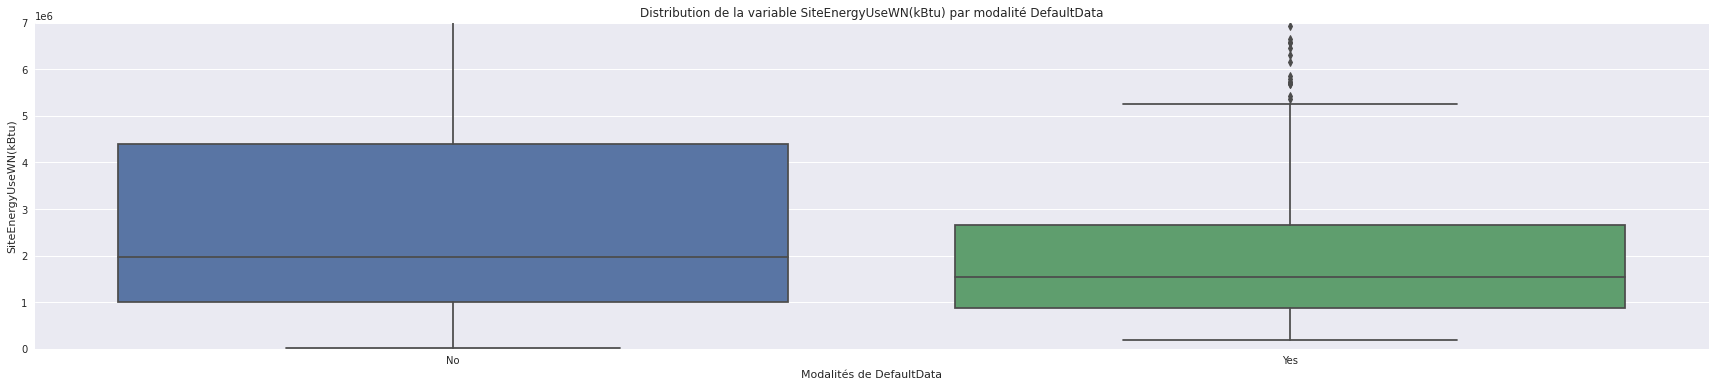

In [33]:
def bivariate_boxplot(data, quali, quanti, ylim=0,set_ylim=False, figsize=(30,6)):
    """
    Draw boxplot for a couple of variables. One is quantitative. The other qualitative.
    
    Args:
        data(Dataframe): A dataframe
        
        quali(Series): Qualitative variable
        
        quanti(Series): Quantitative variable
        
    Returns:
        A boxplot
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sns.boxplot(data=data, x=quali, y=quanti )
    ax.set_title(f"Distribution de la variable {quanti} par modalité {quali}")
    ax.set_xlabel(f"Modalités de {quali}")
    ax.set_ylabel(f"{quanti}")
    if set_ylim == True:
        ax.set_ylim(bottom=0, top=ylim)

    plt.show()
    
bivariate_boxplot(filtered_data, "DefaultData", "SiteEnergyUseWN(kBtu)", set_ylim=True, ylim=0.7e7)

La variable SiteEnergyUseWN(NkBtu) a une médiane plus élevée et une distribution plus étalée sur la modalité No de la variable DefaultData.

Faisons la même étude pour la variable  GHGEmissions(MetricTonsCO2e).

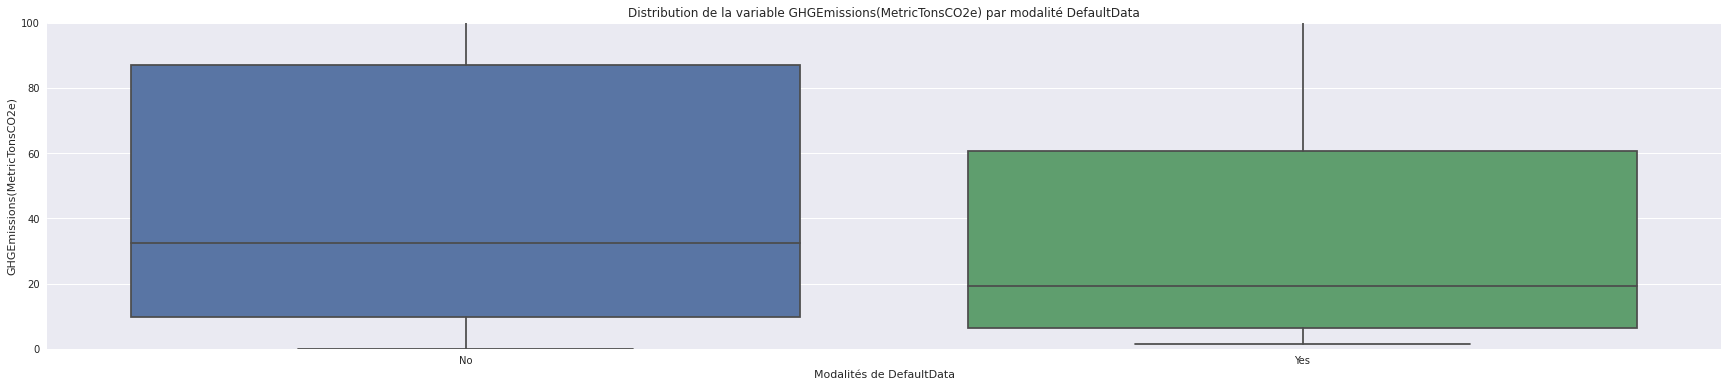

In [34]:
bivariate_boxplot(filtered_data, "DefaultData", "GHGEmissions(MetricTonsCO2e)", set_ylim=True, ylim=100)

Il apparaît clairement que la distribution de la variable GHGEmissions(MetricTonsCO2e) diffère selon la modalité de la varibale DefaultData. 

Malgré le fait que la variable semble discriminante, à défaut de pouvoir l'expliquer, nous décidons de ne pas la conserver.

In [35]:
filtered_data.drop(columns = "DefaultData", inplace=True)
print(f"Nombre de variables restantes {filtered_data.shape[1]}")

Nombre de variables restantes 25


## Analyse des variables à prédire

### SiteEnergyUseWN(kBtu)

#### Analyse de la distribution

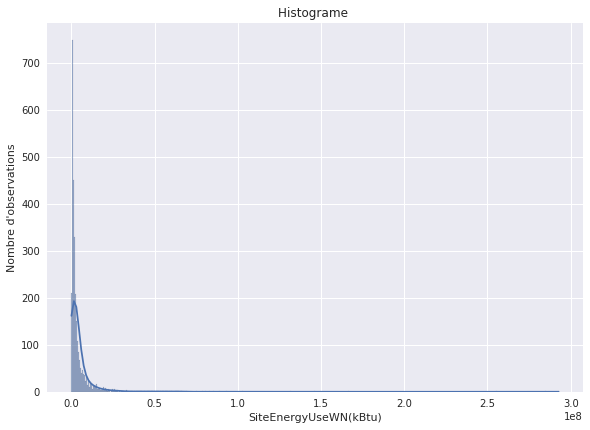

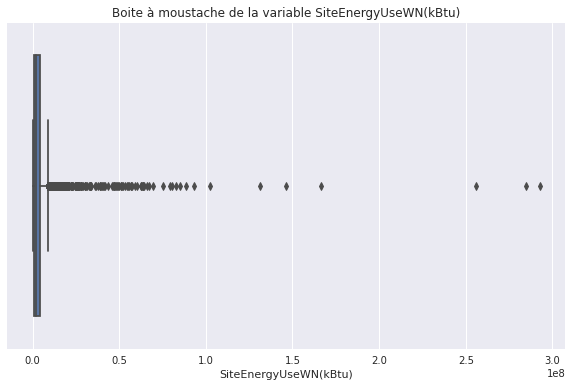

----------------------------------------------------------------------------------------------------


count    2.933000e+03
mean     4.885725e+06
std      1.310088e+07
min      1.144100e+04
25%      9.738990e+05
50%      1.868740e+06
75%      4.055974e+06
max      2.927463e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [36]:
def distribution_plots(data, col, bins=500,  hide_outliers=False):

    hist_plot = sns.displot( data=data, x=col, bins=bins, kde=True)
    hist_plot.fig.set_figwidth(9)
    hist_plot.fig.set_figheight(6)
    plt.ylabel("Nombre d'observations")
    plt.xlabel(f"{col}")
    if hide_outliers == True:
        plt.xlim(left= 0, right=(data[col].quantile(0.75) + 1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))))
    plt.title("Histograme ")
    plt.show(block=False)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax = sns.boxplot(data=data, x=col)
    ax.set_title(f"Boite à moustache de la variable {col}")
    if hide_outliers == True:
        ax.set_xlim(left=0, right=(data[col].quantile(0.75) + 1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))))
    ax.set_xlabel(f"{col}")
    plt.show(block=False)

    print("-" * 100)
    display(data[col].describe())

distribution_plots(data_2015,"SiteEnergyUseWN(kBtu)")

Nous constatons une une distribution concentrée autour des valeurs les plus faibles de la variable. Les graphiques n'offrent pas un niveau de précision assez élevé. Nous les réalisons à nouveau, sans les valeurs atypiques.

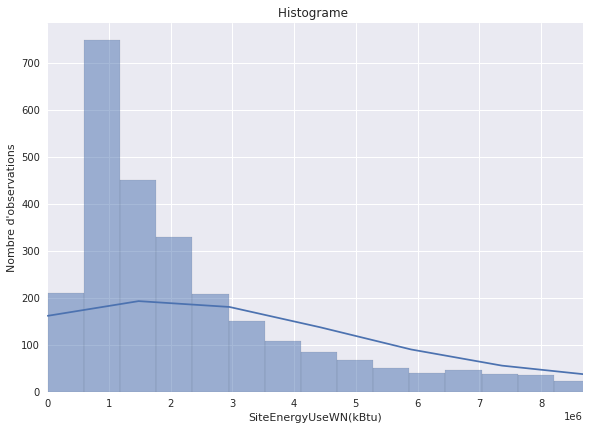

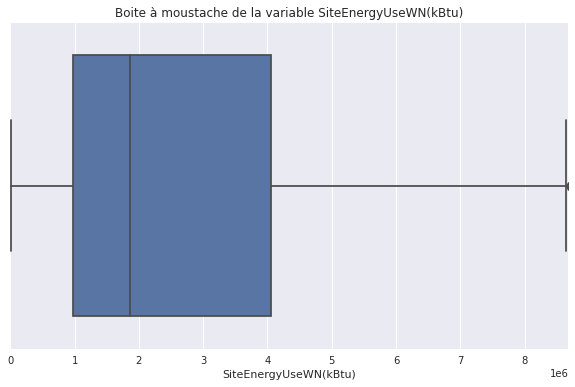

----------------------------------------------------------------------------------------------------


count    2.933000e+03
mean     4.885725e+06
std      1.310088e+07
min      1.144100e+04
25%      9.738990e+05
50%      1.868740e+06
75%      4.055974e+06
max      2.927463e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [37]:
distribution_plots(data_2015,"SiteEnergyUseWN(kBtu)", bins=500, hide_outliers=True)

Nous constatons qu'un nombre important d'observations avec des valeurs dans un ordre de grandeur entre entre 50 000 et un peu plus de 100 000 kBtu. 75% des observations ont une valeur entre 11 441 et 4 055 097 kBtu.

#### Valeurs atypiques

En plus d'avoir une distribution très concentrée, la variable comporte de nombreuses valeurs atypiques. Observons les

In [38]:
def check_outliers(df, col):
    """
    Retrive all outliers which are out or a 3 IQR range for a single series.
    
    Args:
        df(Dataframe): A pandas dataframe
        col(Dataframe series): A pandas Series to check outliers
        
    Returns 
        q1(float): value of the first quartile
        q3(float): value of the third quartile
        iqr(float): inter quartile range 
        outliers(dataframe): Filtered datarame with ouliers values
    """
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers = df[(df[col] < fence_low) | (df[col] > fence_high)]
    
    print(f"Premier quartile: {q1}")
    print(f"Troisième quartile: {q3}")
    print(f"Intervale inter-quartiles: {iqr}")
    print(f"Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: {outliers.shape[0]} ")
    print(f"Proportions des valeurs atypiques {outliers.shape[0]/df.shape[0]*100:.2f}%")
    
    return q1, q3, iqr, outliers

_, _, _, energy_outliers = check_outliers(data_2015, "SiteEnergyUseWN(kBtu)")
pd.set_option("display.max_columns", 37)
print("20 plus hautes valeurs atypiques")
display(energy_outliers.sort_values("SiteEnergyUseWN(kBtu)", ascending=False).head(20))

Premier quartile: 973899.0
Troisième quartile: 4055974.0
Intervale inter-quartiles: 3082075.0
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 347 
Proportions des valeurs atypiques 11.83%
20 plus hautes valeurs atypiques


,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Zip Codes
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
828,NonResidential,Hospital,SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus,1978201096,"{'latitude': '47.608951', 'longitude': '-122.3...",3,EAST,1994,1,14.0,1765970,0,1765970,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,...,59.0,174.9,178.6,374.6,372.0,286685536.0,292746272.0,127869744.0,41161340.0,140448322.0,183733.0,18373320.0,0.0,11824.89,6.35,No,Compliant,19578
753,NonResidential,Other,THE WESTIN BUILDING,659000950,"{'latitude': '47.61435318', 'longitude': '-122...",7,DOWNTOWN,1981,1,33.0,429405,0,429405,"Data Center, Office",Data Center,218997.0,Office,210409.0,...,71.0,663.4,663.4,2082.3,2082.3,284867168.0,284867168.0,0.0,83445048.0,284726322.0,1526.0,152639.0,0.0,1992.96,1.79,No,Compliant,19576
198,NonResidential,Hospital,SEATTLE CHILDREN'S HOSPITAL (MAIN CAMPUS),2982800005,"{'latitude': '47.66356652', 'longitude': '-122...",4,NORTHEAST,1953,1,10.0,879000,0,879000,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,...,13.0,285.8,290.9,572.9,561.7,251191824.0,255669168.0,0.0,33629360.0,114748139.0,1364484.0,136448438.0,0.0,8046.70,8.59,No,Compliant,18383
49859,Campus,Other,AMGEN INC. MASTER CAMPUS,7666201725,"{'latitude': '47.62811223', 'longitude': '-122...",7,MAGNOLIA / QUEEN ANNE,2002,7,4.0,808520,376000,432520,Other,Other,808520.0,NaN,NaN,...,NaN,194.9,206.0,403.0,414.6,157606480.0,166523440.0,0.0,22490860.0,76742000.0,808676.0,80867644.0,0.0,4829.86,5.57,No,Compliant,19575
477,Campus,Other,FHCRC - Weintraub/Hutchinson/Thomas Bldgs Campus,1984200455,"{'latitude': '47.6286355', 'longitude': '-122....",3,LAKE UNION,1997,3,5.0,535947,195283,340664,"Other, Parking",Other,535947.0,Parking,103983.0,...,NaN,254.2,272.9,536.6,546.4,136241424.0,146248640.0,0.0,20265210.0,69147767.0,670965.0,67096519.0,0.0,4045.53,6.99,No,Compliant,18390
22062,Campus,College/University,SEATTLE UNIVERSITY (MAIN CAMPUS),2254500880,"{'latitude': '47.60869656', 'longitude': '-122...",3,EAST,1939,39,2.0,2200000,0,2200000,"College/University, Parking",College/University,1719643.0,Parking,318960.0,...,NaN,66.9,76.4,146.1,158.3,115080128.0,131427232.0,0.0,18292370.0,62416157.0,526666.0,52666569.0,0.0,3232.23,1.35,No,Compliant,19578
23113,NonResidential,Medical Office,GROUP HEALTH HOSPITAL-SEATTLE,3117000005,"{'latitude': '47.61997738', 'longitude': '-122...",3,EAST,1964,1,3.0,591981,0,591981,"Medical Office, Other/Specialty Hospital, Outp...",Medical Office,520187.0,Parking,282392.0,...,61.0,177.3,173.4,358.7,346.3,104977248.0,102641984.0,0.0,14319970.0,48861766.0,561175.0,56117500.0,0.0,3321.02,5.25,Yes,Compliant,18789
775,NonResidential,Large Office,COLUMBIA CENTER,942000640,"{'latitude': '47.60466039', 'longitude': '-122...",7,DOWNTOWN,1985,1,76.0,1952220,319400,1632820,"Office, Parking",Office,1680937.0,Parking,319368.0,...,84.0,56.3,55.5,171.9,169.1,94560088.0,93255440.0,0.0,26597630.0,90754881.0,38090.0,3808965.0,0.0,834.96,0.23,No,Compliant,18379
63,NonResidential,Hotel,SHERATON HOTEL,1976700095,"{'latitude': '47.61101988', 'longitude': '-122...",7,DOWNTOWN,1982,1,34.0,994212,146694,847518,"Hotel, Parking, Swimming Pool",Hotel,994212.0,Parking,117668.0,...,60.0,85.9,89.3,187.3,191.6,85357952.0

En observant l'extrait des valeurs atypques nous percevons une représentation plus importante de certaines modalités de la variable "LargestPropertyUseType". Vérifions le phénomène en réalisant un tableau de contingeances des valeurs atypiques selon le modalités de la variable BuildingType.

In [39]:
def create_pivot_table(data, col):
    """
    Build pivot table.
    
    Args:
        data(dataframe): A dataframe
        
        col(Series): A series to use as index
        
    Returns:
        A pivot table
    """
    pivot_table = data.pivot_table(values = "PropertyName",
                     index = [col],
                    aggfunc = "count")

    pivot_table.rename(columns = {'PropertyName':'nombre_observations'}, inplace = True)
    pivot_table.sort_values("nombre_observations", ascending=False, inplace=True)
    return pivot_table
    
energy_outliers_by_largestpropertytype = create_pivot_table(energy_outliers, "LargestPropertyUseType")
display(energy_outliers_by_largestpropertytype)

,nombre_observations
LargestPropertyUseType,
Office,97
Multifamily Housing,54
Other,21
Medical Office,20
Hotel,18
Supermarket/Grocery Store,17
Retail Store,11
Parking,11
Senior Care Community,10


Nous constatons que certains modalités sont plus représentées. Les trois première sont Office, Other, Multifamily Housing et Other. Vérifions si cette répartition se généralise à l'ensemble des données. 

In [40]:
largest_property_type_pivot = create_pivot_table(data_2015, "LargestPropertyUseType")
display(largest_property_type_pivot)

,nombre_observations
LargestPropertyUseType,
Multifamily Housing,1447
Office,425
Non-Refrigerated Warehouse,176
K-12 School,90
Other,88
Retail Store,78
Hotel,57
Worship Facility,56
Distribution Center,46


Si les modalités Multifamilly Housing et Office restent en tête, on observe certaines dissimilarités de rangs. On peut émettre l'hypothèse que ces modalités sont plus représentées dans les valeurs atypiques. 
A titre d'exemple citons la modalité Hotal. A l'inverse la modalité K 12-School est moins représentée dans les valeurs atypiques.


Continuons d'observer la idstribution de la variable selon la modalité de la variable  "LargestPropertyUseType".

#### Liaisons avec la variable  "LargestPropertyUseType"

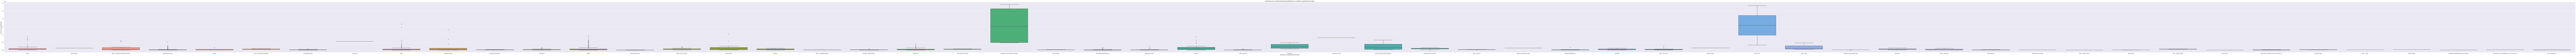

In [41]:
bivariate_boxplot(filtered_data, "LargestPropertyUseType", "SiteEnergyUseWN(kBtu)", figsize=(500,10))

On observe des distributions différentes de la variable SiteEnergyUseWN(kBtu) par modalité de la variable LargestPropertyUseType. A noter que les modalité Hospital et Data Center ont une mediane bien supérieurs à tous les troisième quartile des autres modalités ainsi qu'une distribnution beaucoup plus étalée. Voyons combien il y a d'observations pour ces modalités.

In [42]:
print(f"Nombre d'hopitaux: {filtered_data[filtered_data['LargestPropertyUseType'] == 'Hospital (General Medical & Surgical)'].shape[0]} ")
print(f"Nombre de data centers:{filtered_data[filtered_data['LargestPropertyUseType'] == 'Data Center'].shape[0]}")

Nombre d'hopitaux: 4 
Nombre de data centers:2


Ces deux modalités ont certe des distributions remarcables pour la consommation d'énergie mais sont peux représentées.

Terminons l'étude de la liaison en faisant un test statistique de Kruskal-Wallis.

In [43]:
from scipy.stats import kruskal
kruskal(filtered_data["SiteEnergyUseWN(kBtu)"], filtered_data["LargestPropertyUseType"].notna())

KruskalResult(statistic=4937.5088061456, pvalue=0.0)

La p value confirme que nous pouvons rejeter l'indépendance de la variable SiteEnergyUseWN(kBtu) vis à vis des modalités de la variable PrimaryPropertyType.

#### Liaison avec la variable BuildingType

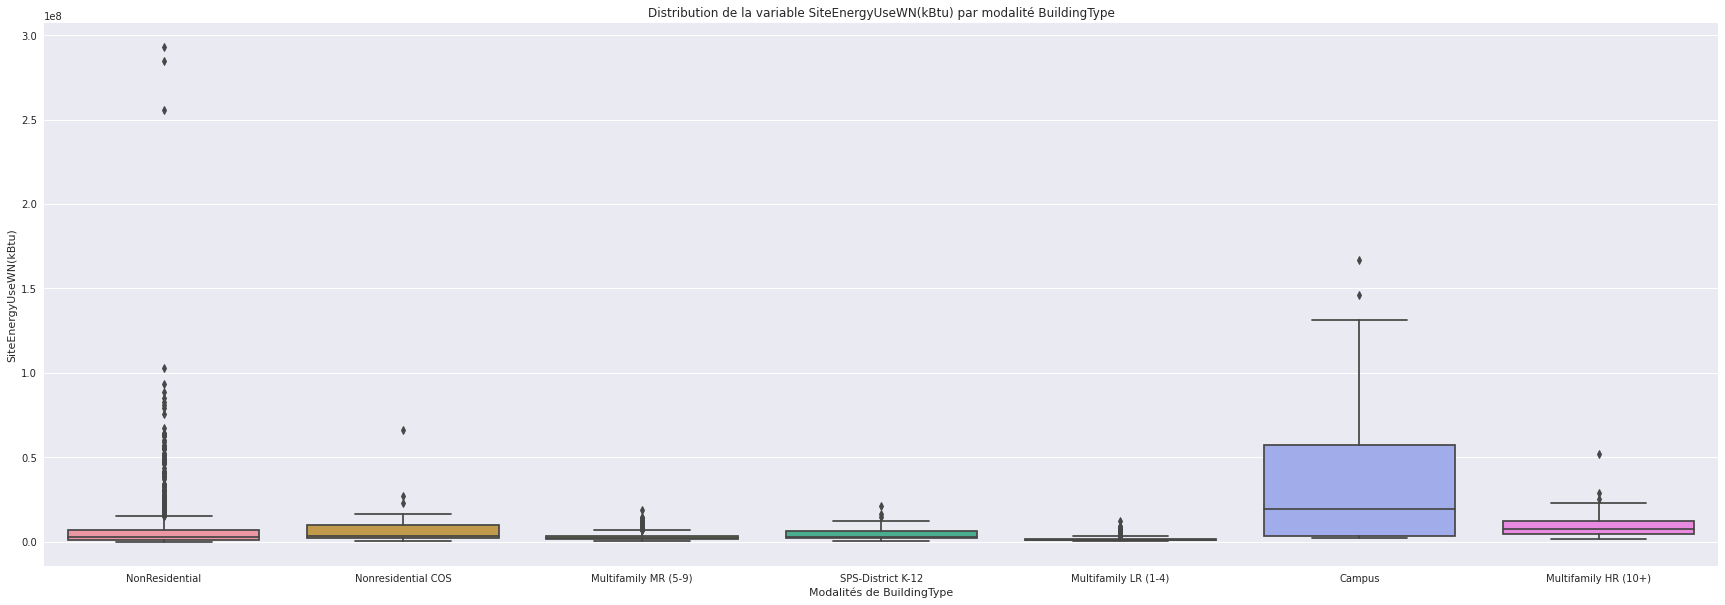

In [44]:
bivariate_boxplot(filtered_data, "BuildingType", "SiteEnergyUseWN(kBtu)", figsize=(30,10))

On constate que la modalité Campus a une médiane bien supérieur au troisième quartile des autres modalités ainsi qu'une distribution beaucoup plus étalée. Vérifions le nombre d'observations qui ont cette modalité.

In [45]:
print(f"Nombre de cmapus:{filtered_data[filtered_data['BuildingType'] == 'Campus'].shape[0]}")

Nombre de cmapus:16


Même si la modalité a une distribution remarcable pour la consommation d'énergie, elle reste peu représentée.
Testons la liaisons entre la variable BuildingType et SiteEnergyUseWN(kBtu) avec un test de Kruska-Wallis.

In [46]:
kruskal(filtered_data["SiteEnergyUseWN(kBtu)"], filtered_data["BuildingType"].notna())

KruskalResult(statistic=5027.142940626053, pvalue=0.0)

La p valeur permet de rejeter l'hypothèse d'indépendance.

#### Liaison avec la variable Neighborhood

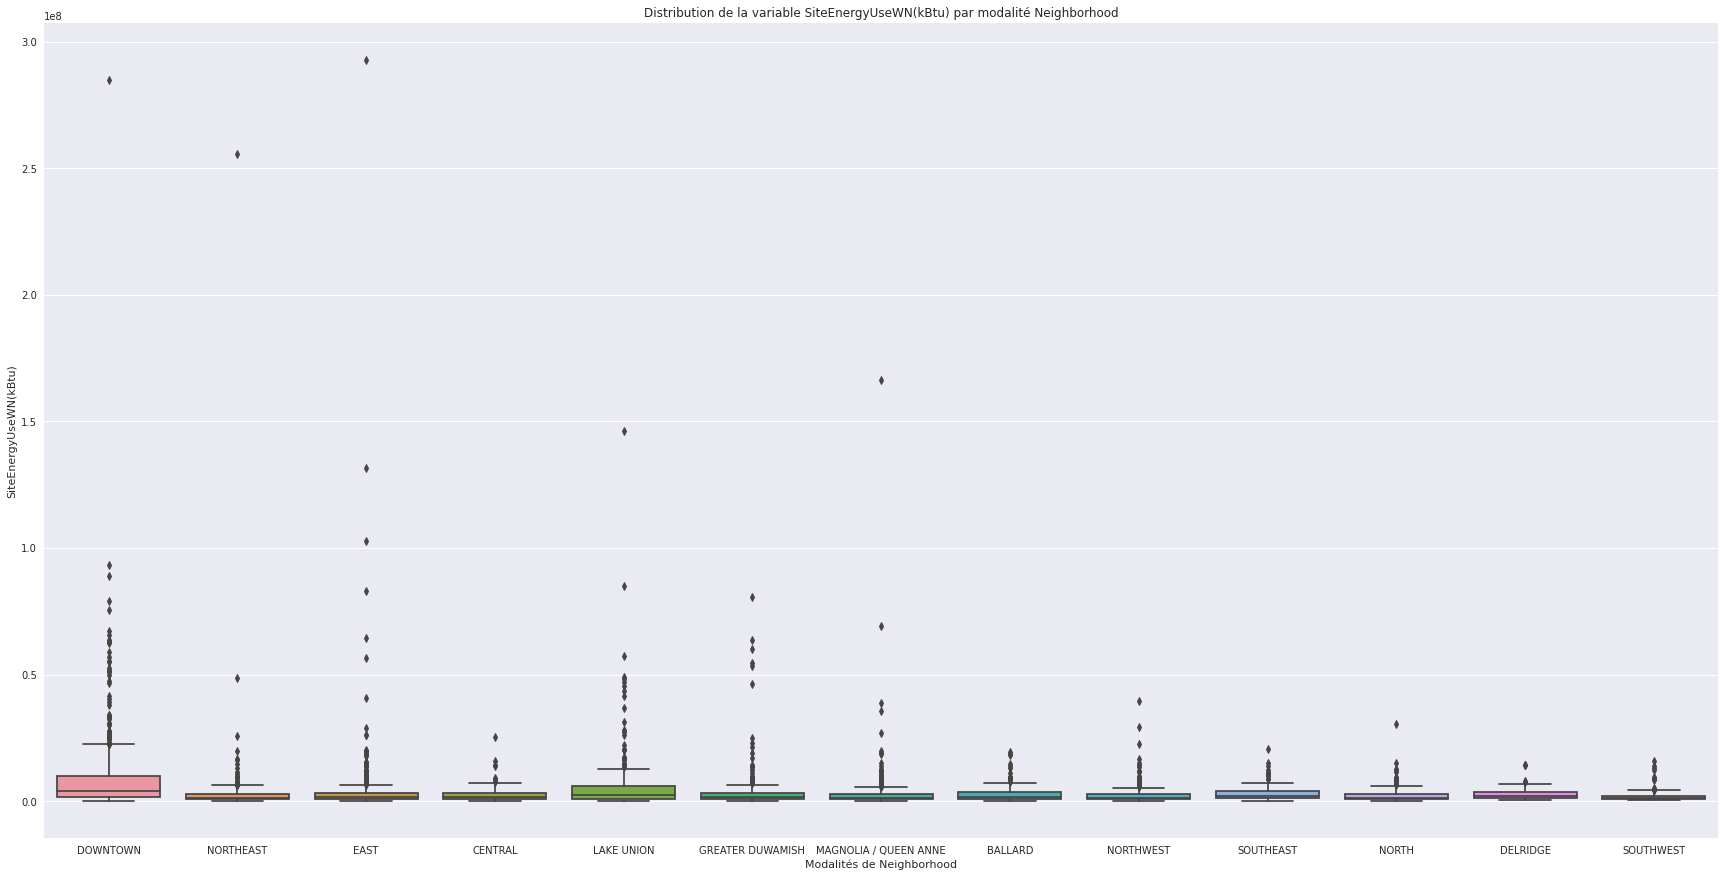

In [47]:
bivariate_boxplot(filtered_data, "Neighborhood", "SiteEnergyUseWN(kBtu)",figsize=(30,15))

Pour le squartiers de Downtown et Lake Union nous constatons une distribution sensiblement plus étalée. Maintenant les différences de distributions ne sont pas très marquées.

Vérifions une liaison éventuelle avec un test de Kruskal-Wallis.

In [48]:
kruskal(filtered_data["SiteEnergyUseWN(kBtu)"], filtered_data["Neighborhood"].notna())

KruskalResult(statistic=5027.142940626053, pvalue=0.0)

La p valeur permet de rejeter l'hypothèse d'indépendance. Maintenant la différence de distribution étant faible par modalité de la variable "Neighboorhood" nous ne conserverons pas cettes variables lors du filtrage final.

### GHGEmissions(MetricTonsCO2e)

Commençons par observer la distribution de la variable.

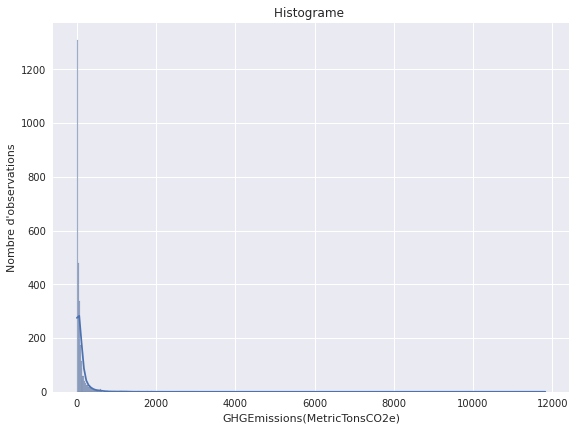

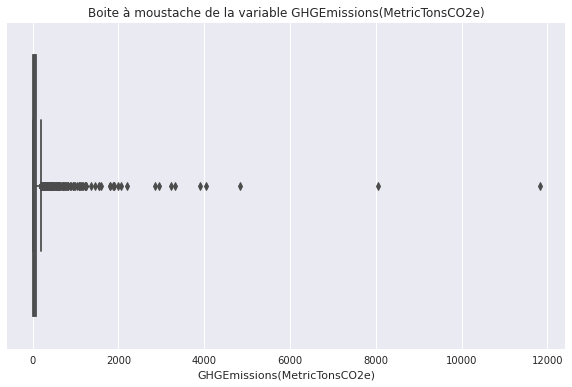

----------------------------------------------------------------------------------------------------


count     2933.000000
mean        98.579236
std        360.138301
min          0.080000
25%          8.700000
50%         30.190000
75%         79.980000
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [49]:
distribution_plots(filtered_data,"GHGEmissions(MetricTonsCO2e)")

Les observation sont très concentrés autour des valeurs faibles. Refaissons ces digrammes sans les valeurs atypiques.

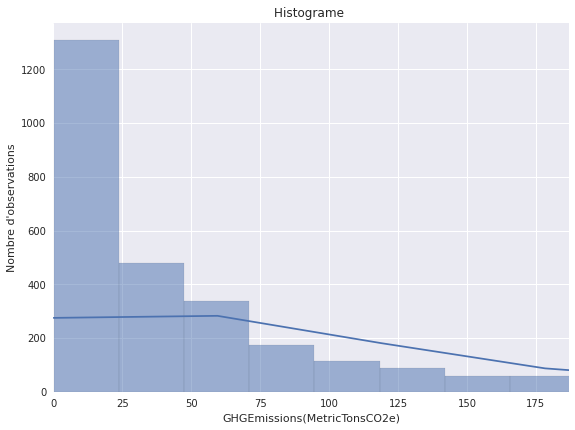

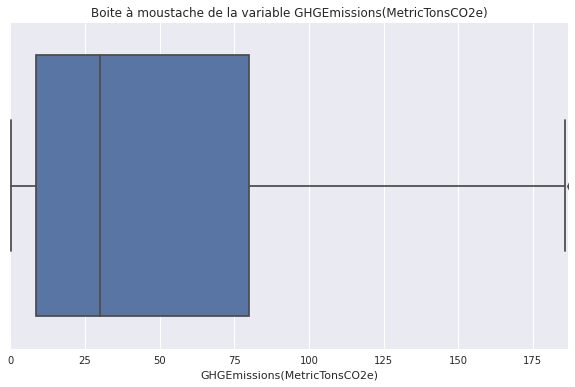

----------------------------------------------------------------------------------------------------


count     2933.000000
mean        98.579236
std        360.138301
min          0.080000
25%          8.700000
50%         30.190000
75%         79.980000
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [50]:
distribution_plots(data_2015,"GHGEmissions(MetricTonsCO2e)", hide_outliers=True, bins=500)

Nous pouvons préciser que la distribution de la variable est concentrée en dessous de 100 Tonnes. 

Observons à pésent les valeurs atypiques.

In [51]:
_, _, _, co2_outliers = check_outliers(filtered_data, "GHGEmissions(MetricTonsCO2e)")
pd.set_option("display.max_columns", 37)
print("20 plus hautes valeurs atypiques")
display(co2_outliers.sort_values("GHGEmissions(MetricTonsCO2e)", ascending=False).head(20))

Premier quartile: 8.7
Troisième quartile: 79.98
Intervale inter-quartiles: 71.28
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 320 
Proportions des valeurs atypiques 10.91%
20 plus hautes valeurs atypiques


,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e)
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,
828,NonResidential,Hospital,SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus,EAST,1994,1,14.0,1765970,0,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1639334.0,Parking,441551.0,NaN,NaN,59.0,286685536.0,292746272.0,127869744.0,41161340.0,140448322.0,18373320.0,0.0,11824.89
198,NonResidential,Hospital,SEATTLE CHILDREN'S HOSPITAL (MAIN CAMPUS),NORTHEAST,1953,1,10.0,879000,0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),879000.0,NaN,NaN,NaN,NaN,13.0,251191824.0,255669168.0,0.0,33629360.0,114748139.0,136448438.0,0.0,8046.70
49859,Campus,Other,AMGEN INC. MASTER CAMPUS,MAGNOLIA / QUEEN ANNE,2002,7,4.0,808520,376000,Other,Other,808520.0,NaN,NaN,NaN,NaN,NaN,157606480.0,166523440.0,0.0,22490860.0,76742000.0,80867644.0,0.0,4829.86
477,Campus,Other,FHCRC - Weintraub/Hutchinson/Thomas Bldgs Campus,LAKE UNION,1997,3,5.0,535947,195283,"Other, Parking",Other,535947.0,Parking,103983.0,NaN,NaN,NaN,136241424.0,146248640.0,0.0,20265210.0,69147767.0,67096519.0,0.0,4045.53
49940,NonResidential,Hospital,VIRGINIA MASON- CENTRAL PAVILLION,EAST,1920,1,8.0,374466,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,78652064.0,82941480.0,47648276.0,9086690.0,31005073.0,0.0,0.0,3894.01
23113,NonResidential,Medical Office,GROUP HEALTH HOSPITAL-SEATTLE,EAST,1964,1,3.0,591981,0,"Medical Office, Other/Specialty Hospital, Outp...",Medical Office,520187.0,Parking,282392.0,Other/Specialty Hospital,54159.0,61.0,104977248.0,102641984.0,0.0,14319970.0,48861766.0,56117500.0,0.0,3321.02
22062,Campus,College/University,SEATTLE UNIVERSITY (MAIN CAMPUS),EAST,1939,39,2.0,2200000,0,"College/University, Parking",College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,115080128.0,131427232.0,0.0,18292370.0,62416157.0,52666569.0,0.0,3232.23
389,NonResidential,Hotel,FAIRMONT OLYMPIC HOTEL,DOWNTOWN,1923,1,12.0,542305,0,"Hotel, Office, Retail Store",Hotel,497900.0,Retail Store,28605.0,Office,15800.0,22.0,64547116.0,67162360.0,32659986.0,8109597.0,27671094.0,4217186.0,0.0,2937.83
63,NonResidential,Hotel,SHERATON HOTEL,DOWNTOWN,1982,1,34.0,994212,146694,"Hotel, Parking, Swimming Pool",Hotel,994212.0,Parking,117668.0,Swimming Pool,0.0,60.0,85357952.0,88771488.0,16229832.0,13200400.0,45041634.0,24088353.0,0.0,2846.07


A l'image de la variable SiteEnergyUseWN(kBtu), plusieurs modalités de la variable PrimaryPropertyType sont très représentées dans les 20 plus grandes valeurs atypiques de la variableGHGEmissions(MetricTonsCO2e).

Observons plus largement la répartition des outliers par moadalité de la variabe LargestPropertyUseType et comparons la avec la répartition sur l'ensemble du jeu de données.

In [52]:
co2_outliers_by_primarypropertytype = create_pivot_table(co2_outliers, "LargestPropertyUseType")
display(co2_outliers_by_primarypropertytype)    

,nombre_observations
LargestPropertyUseType,
Multifamily Housing,61
Office,56
Hotel,31
Other,21
Medical Office,15
Senior Care Community,13
Supermarket/Grocery Store,13
K-12 School,13
Retail Store,9


In [53]:
largest_property_type_pivot = create_pivot_table(data_2015, "LargestPropertyUseType")
display(largest_property_type_pivot)

,nombre_observations
LargestPropertyUseType,
Multifamily Housing,1447
Office,425
Non-Refrigerated Warehouse,176
K-12 School,90
Other,88
Retail Store,78
Hotel,57
Worship Facility,56
Distribution Center,46


Comme poour la consommation d'énergie, nous notons des dissiilarités de rang. Encore une fois la modalité Hotel a un rang plus élevé dans les valeurs atypiques.

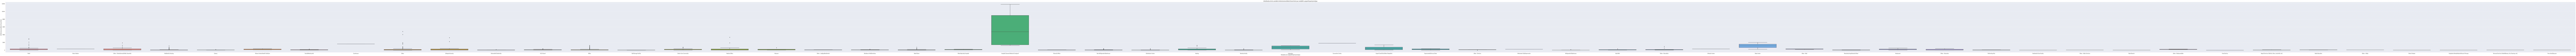

In [54]:
bivariate_boxplot(filtered_data, "LargestPropertyUseType", "GHGEmissions(MetricTonsCO2e)", figsize=(500,10))

A l'image de la variable SiteEnergyUseWN(kBtu) la modalité Hospital de la variable LargestPropertyUseType a, pour la variable GHGEmissions(MetricTonsCO2e), une mediane largement au dessus des troisièmes quartiles des autres modalités. Le constat est similaire pour la distribution de cette modalité qui est beaucoup plus étalées.

Vérifions la lisaison entre la variable GHGEmissions(MetricTonsCO2e) et les modalité de la variable PrimaryPropertyType via un test de Krustak-Wallis.

In [55]:
kruskal(filtered_data["GHGEmissions(MetricTonsCO2e)"], filtered_data["PrimaryPropertyType"].notna())

KruskalResult(statistic=4924.8294384487535, pvalue=0.0)

La p value permet de rejeter l'hypothèse d(indépendance. 

#### Liaison avec la variable BuildingType

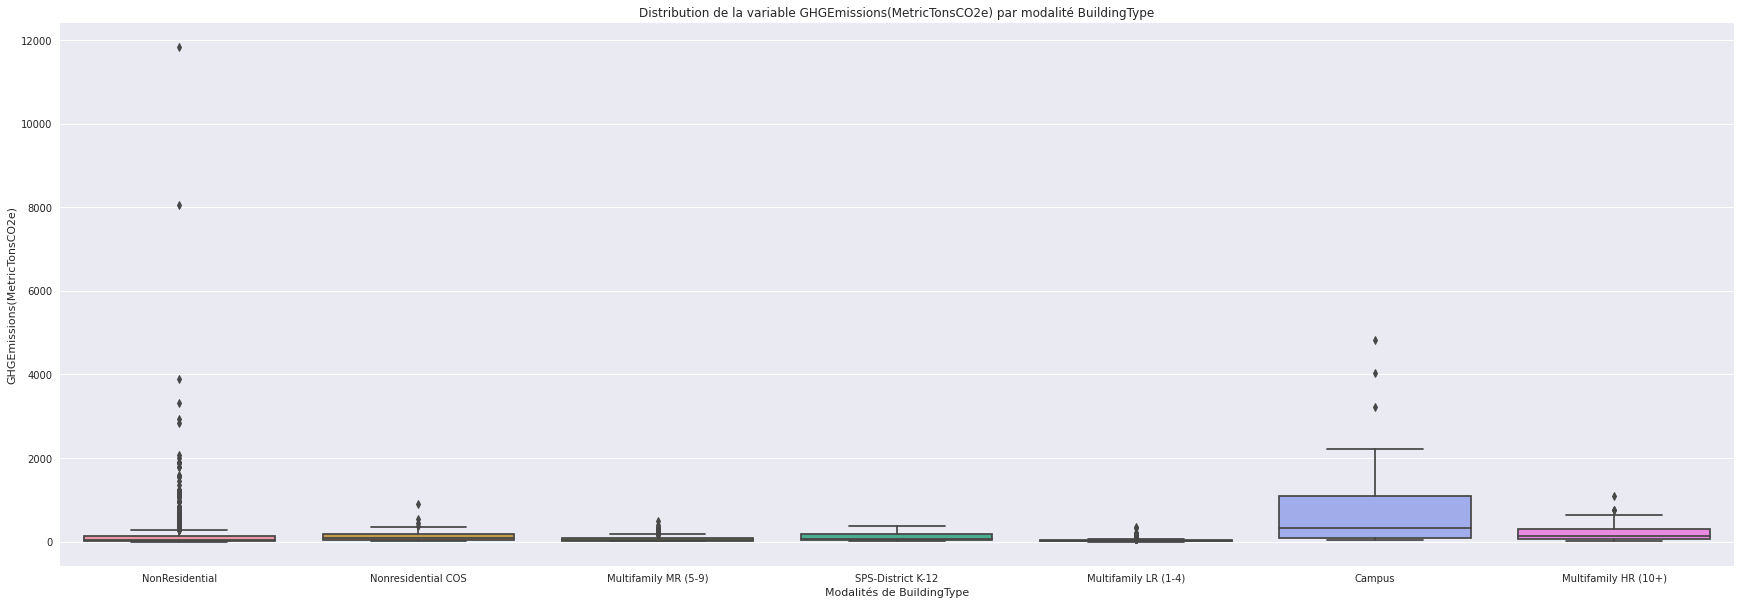

In [56]:
bivariate_boxplot(filtered_data, "BuildingType", "GHGEmissions(MetricTonsCO2e)", figsize=(30,10))

Même si le phénomène est moons marqué qu'avec la variable SiteEnergyUseWN(kBtu), nous constatons tout de même une modalité campus avec un médiane plus élevée et une distribution plus étalée que les autre modalités. 

Testons la liaison avec un test de Kruscal-Wallis.

In [57]:
kruskal(filtered_data["GHGEmissions(MetricTonsCO2e)"], filtered_data["BuildingType"].notna())

KruskalResult(statistic=4924.8294384487535, pvalue=0.0)

La p valeur permeter de rejeter l'hypothèse d'indépendance. 

#### Liaison avec la variable Neighborhood

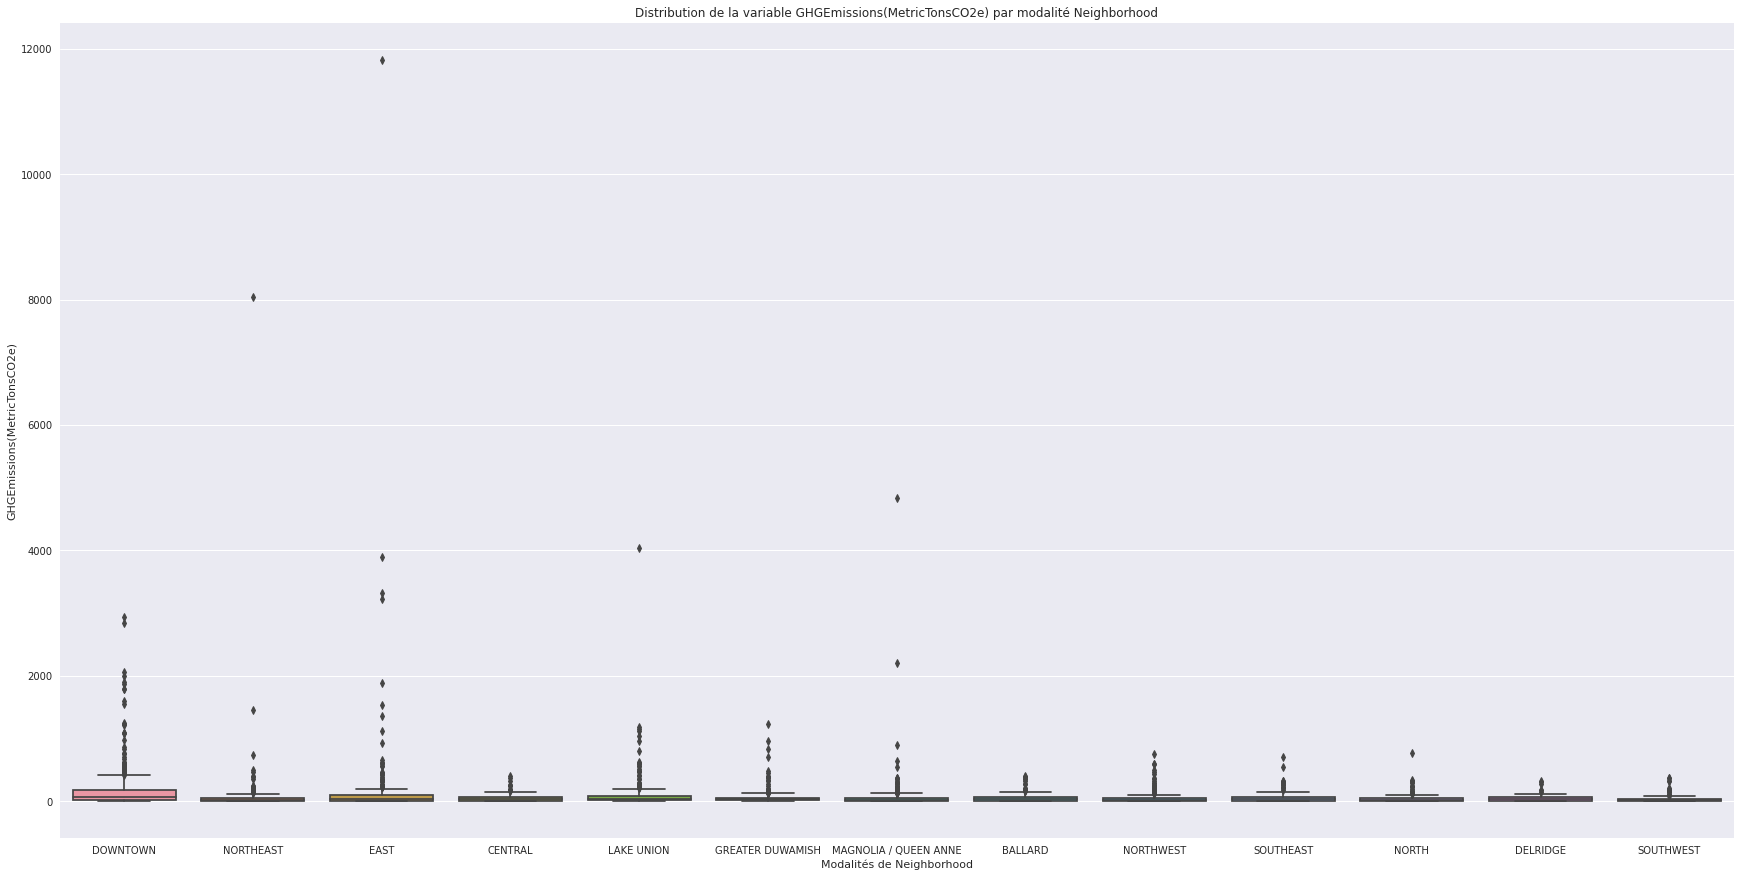

In [58]:
bivariate_boxplot(filtered_data, "Neighborhood", "GHGEmissions(MetricTonsCO2e)",figsize=(30,15))

Le quartier de Downtown a une distribution légèrement plus étalée que les autres quartiers. Les différences de distributions sont une nouvelles fois très peu importantes.

Evaluons la liaison avec un test de Kruskal-Wallis.

In [59]:
kruskal(filtered_data["GHGEmissions(MetricTonsCO2e)"], filtered_data["Neighborhood"].notna())

KruskalResult(statistic=4924.8294384487535, pvalue=0.0)

La p valeur permet de rejeter l'hypothèse d'indépendance.

## Construction de nouvelles variables.

### Transformation de la variable ListOfAllPropertyUseTypes

Nous choisissons de remplacer la liste des activités par observation par une valeur numérique indiquant le nombre d'activités par observations. Observons ensuite la distribution de la variable.

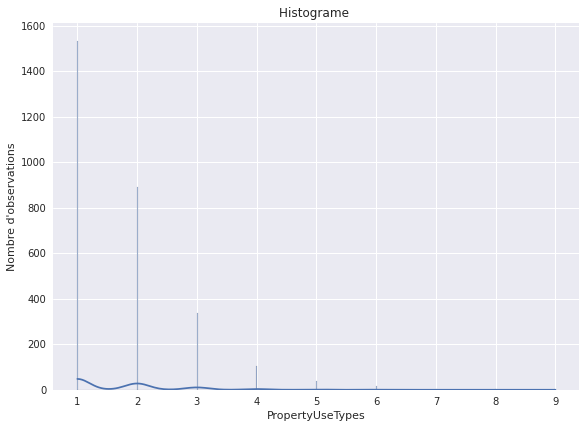

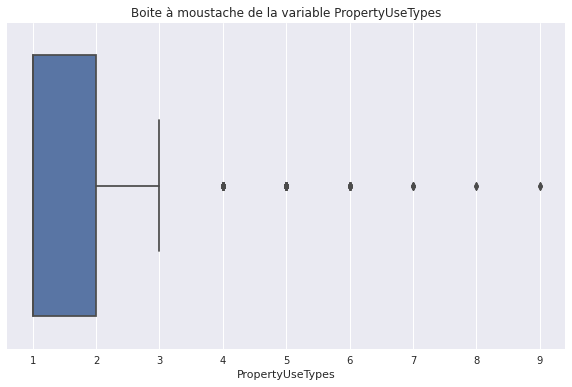

----------------------------------------------------------------------------------------------------


count    2933.000000
mean        1.743607
std         1.012068
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: PropertyUseTypes, dtype: float64

In [60]:
def transform_list_col(row, col, pattern=None):
    """
    Transform a series with values as list of words to count of words
    
    Args:
        row(Dataframe row): A row of a dataframe
        
        col(string): Name a of dataframe Series
        
        pattern(string): A regex pattern if capture specific caracters 
        
    Returns:
        Number of elements of the list
    """
    import re
    
    pattern = re.compile(pattern)
    if row[col] is np.nan:
        return 1
    if len(pattern.findall(str(row[col]))) == 0:
        return len(row[col].split(","))
    else:
        cleaned = pattern.findall(str(row[col]))[0][0]
        return len(cleaned.split(","))
    
filtered_data["PropertyUseTypes"] = filtered_data.apply(transform_list_col, col="ListOfAllPropertyUseTypes", pattern="(^.*)\(.*\)(.*$)", axis=1)
distribution_plots(filtered_data,"PropertyUseTypes")

On constate qu'une majorité d'observation regroupe une à deux activités. Observons les liaisons entre la variable PropertyUseTypes et les variables à prédire. Commençons par la variable SiteEnergyUseWN(kBtu).

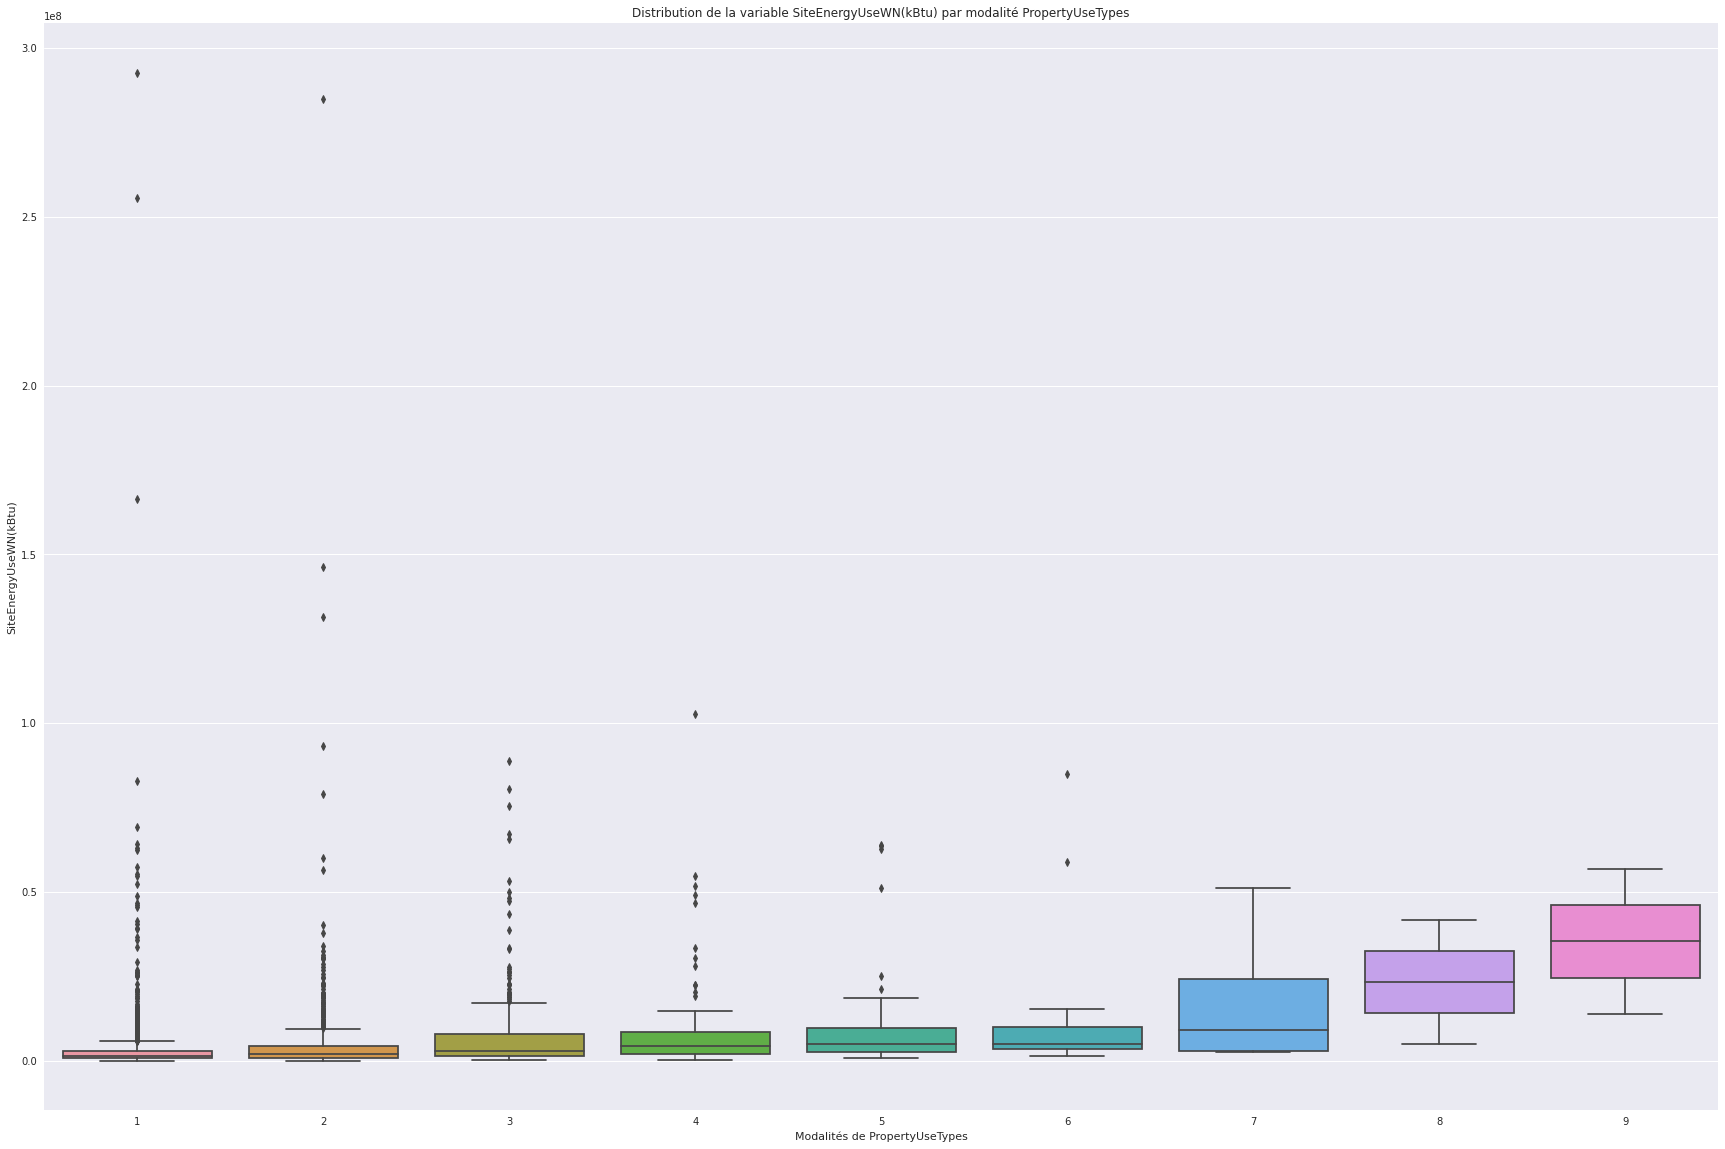

In [61]:
bivariate_boxplot(filtered_data, "PropertyUseTypes", "SiteEnergyUseWN(kBtu)", figsize=(30,20))

On observe une progression de la médiane avec l'accroissement de la valeur de la variable PropertyUseTypes. Nous réalison un test de corrélation de Pearson afin de tester la liaison nous réalisons un test de Spearman.

In [62]:
from scipy.stats import spearmanr
spearmanr(filtered_data["PropertyUseTypes"], filtered_data["SiteEnergyUseWN(kBtu)"])

SpearmanrResult(correlation=0.2483499777189475, pvalue=1.7906489406938695e-42)

La p valeur permet de rejeter l'indépendance des deux variables. 

Continuons avec la variable GHGEmissions(MetricTonsCO2e)

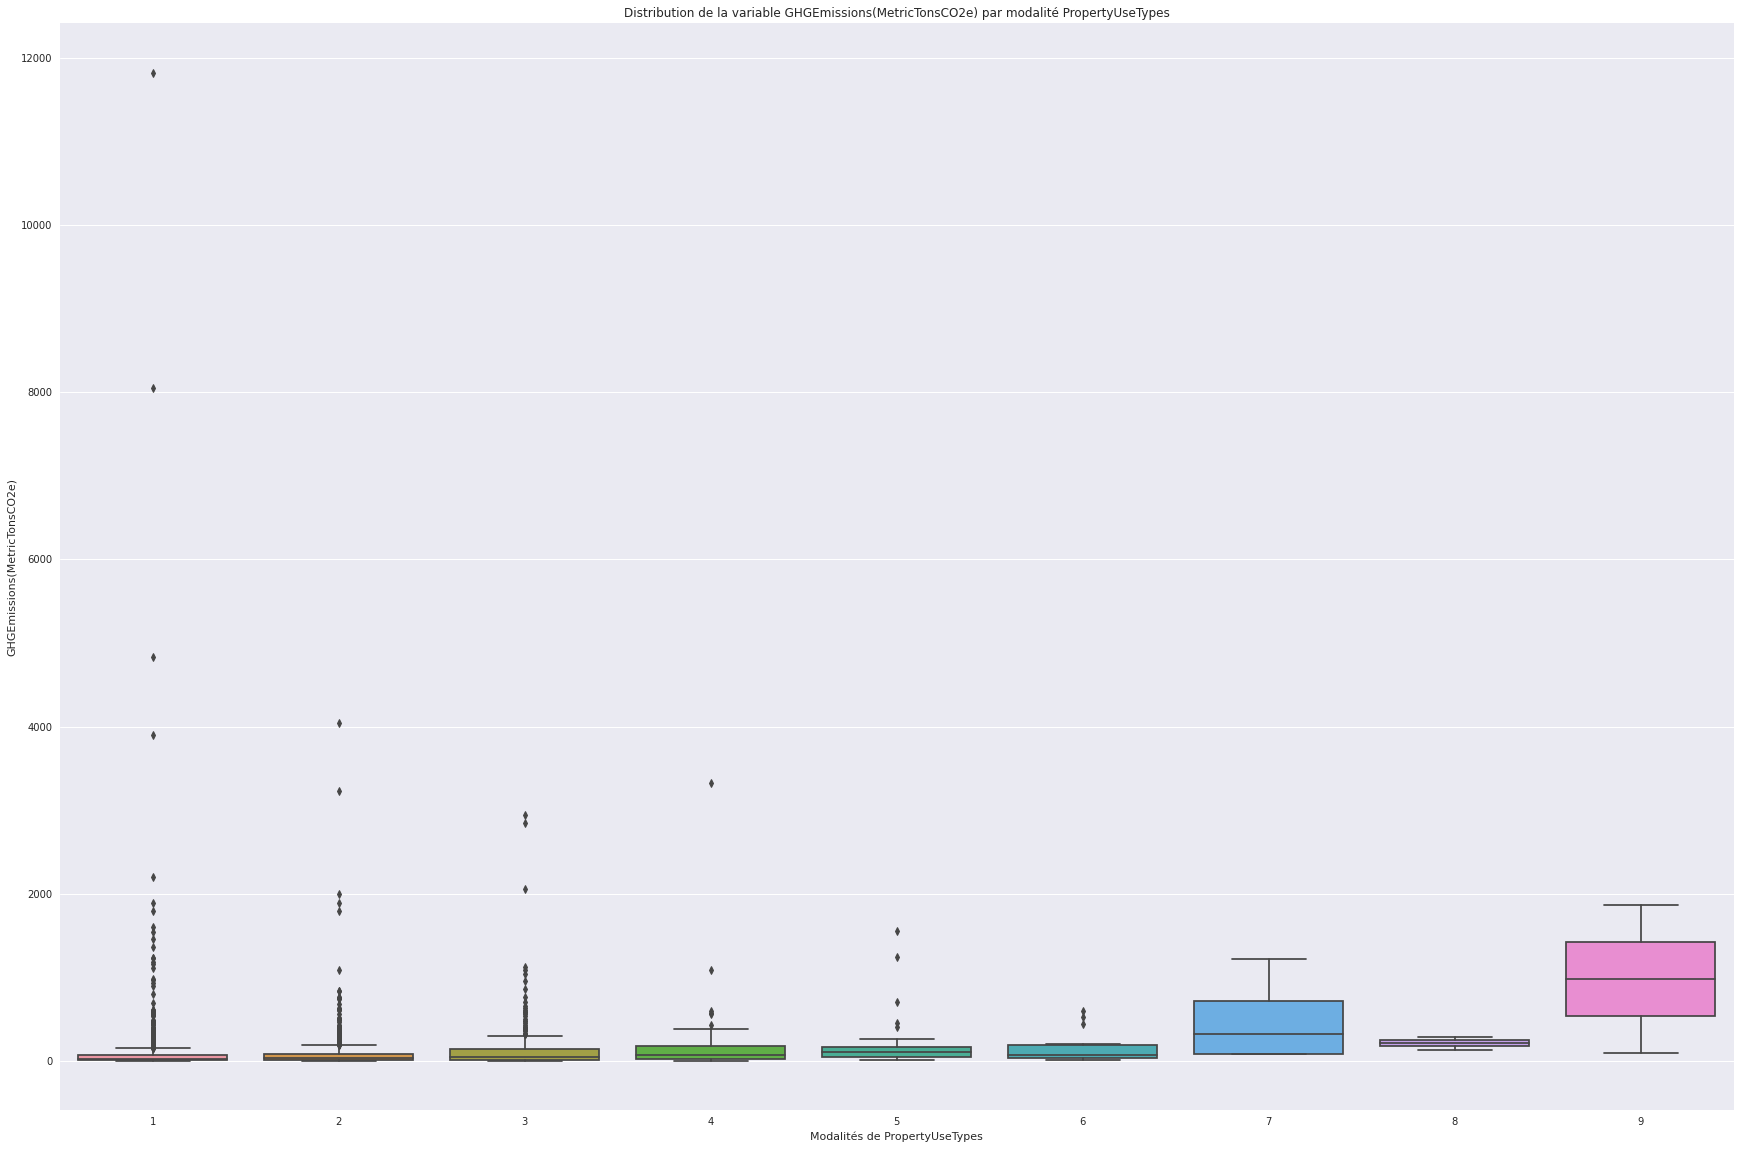

In [63]:
bivariate_boxplot(filtered_data, "PropertyUseTypes", "GHGEmissions(MetricTonsCO2e)", figsize=(30,20))

Nous observons un phénomène similaire à l'exception des observations qui accueillent huit activités.

Nous faisons également un test de correlation de Spearman.

In [64]:
spearmanr(filtered_data["PropertyUseTypes"], filtered_data["GHGEmissions(MetricTonsCO2e)"])

SpearmanrResult(correlation=0.18939034479563704, pvalue=4.352288763965581e-25)

La p valeur permet de rejeter l'hypothèse d'indépendance des variables.

Suite à la construction de la nouvelle variable, nous supprimons la variable "ListOfAllPropertyUseTypes".

In [65]:
filtered_data.drop(columns="ListOfAllPropertyUseTypes", inplace=True)

### Traitement des colonnes LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType

Nous souhaitons remplacer les trois variables d'activités principales par une varibale unique mesurant la proportion de de surface allouées à certaines activités qui ont une distribution significative sur la surface totale.

Pour ce faire nous allons:
- Encoder les modalités de ces variables de manière binaires
- Construire une nouvelle varibale réalisant un OU logique entre chaque varibale / modalité des trois anciennes variables
- Filtrer, via un t-test de student, les nouvelles variables ayant une incidence la plus forte sur la moyenne des variables à prédire
- Gérer les observations où la variable LargestPropertyUseType est absente en imputant par la variable puis en netoyant la valeur
- Calculer la proportion de surface alouée sur la surface totale pour chacune des activiés retenues.

Commençons par revenir sur la variable LargestPropertyUseType. D'évaluer les modalités qui ont la probabilité la plus forte de générer une variation de variables à prédire, nous encodons de manière binaire la variable et rélaliions un diagramme d'information mutuelle.

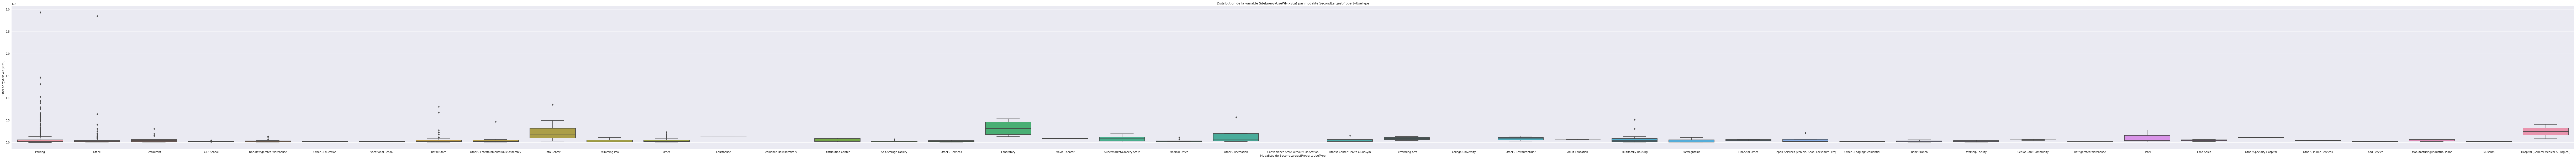

In [66]:
bivariate_boxplot(filtered_data, "SecondLargestPropertyUseType", "SiteEnergyUseWN(kBtu)", figsize=(175,10))

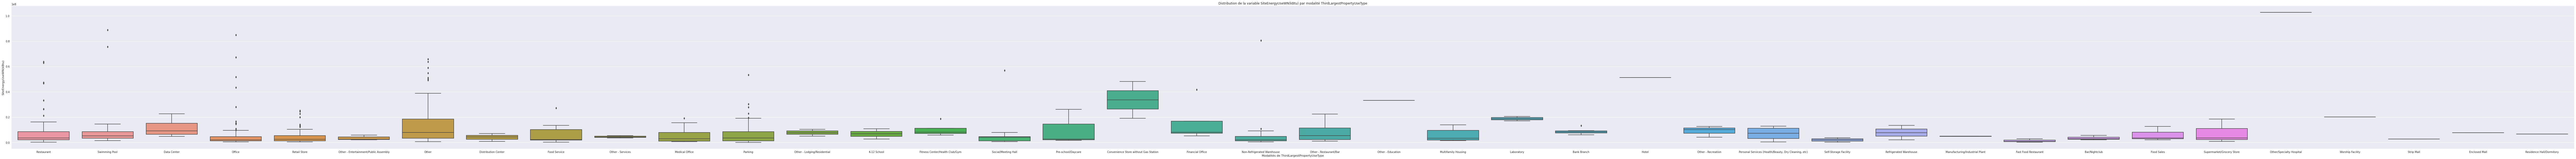

In [67]:
bivariate_boxplot(filtered_data, "ThirdLargestPropertyUseType", "SiteEnergyUseWN(kBtu)", figsize=(175,10))

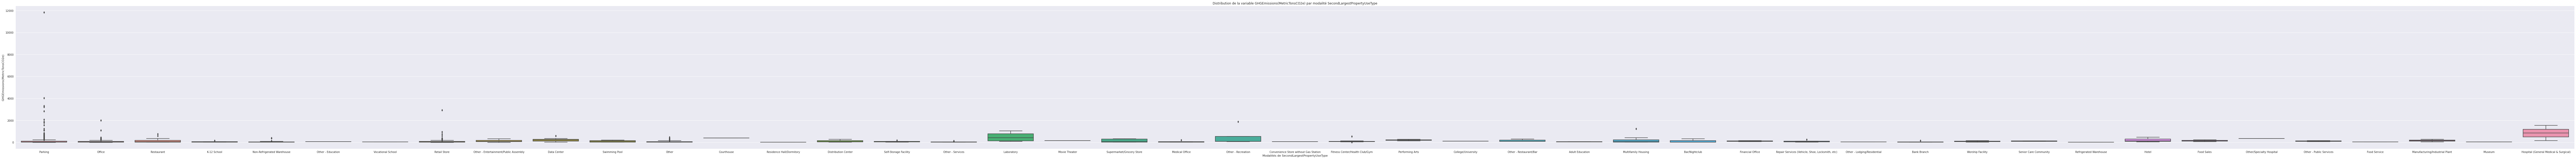

In [68]:
bivariate_boxplot(filtered_data, "SecondLargestPropertyUseType", "GHGEmissions(MetricTonsCO2e)", figsize=(175,10))

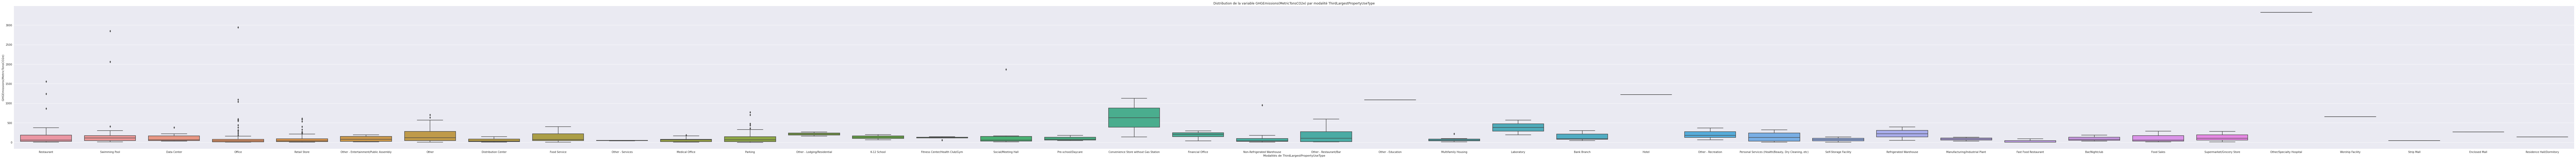

In [69]:
bivariate_boxplot(filtered_data, "ThirdLargestPropertyUseType", "GHGEmissions(MetricTonsCO2e)", figsize=(175,10))

Gobalement si pour la variable LargestPropertyUseType les modalité remarcables sont identiques pour les deux variables à prédire, ce n'est pas les cas pour les seconde et troisième activités. 

Afin de capter les phénomènes nous encodons binairement ces variables et essayons de retrouver les modalités remarcables.

In [70]:
from sklearn.preprocessing import OneHotEncoder

selected_cols = [ 
                 "LargestPropertyUseType",
                 "SecondLargestPropertyUseType", 
                 "ThirdLargestPropertyUseType"
                ]

one_hot = OneHotEncoder(dtype=int, sparse=False)
transformed_activities = pd.DataFrame(one_hot.fit_transform(filtered_data.loc[:,selected_cols]), columns=one_hot.get_feature_names(), index=filtered_data.index )
pd.set_option("display.max_columns", 200)
print("Nombre d'observations par modalité 0 ou 1 des nouvelles variables")
transformed_activities.apply(pd.value_counts)

Nombre d'observations par modalité 0 ou 1 des nouvelles variables


,x0_Adult Education,x0_Automobile Dealership,x0_Bank Branch,x0_College/University,x0_Convention Center,x0_Courthouse,x0_Data Center,x0_Distribution Center,x0_Financial Office,x0_Fitness Center/Health Club/Gym,x0_Food Service,x0_Hospital (General Medical & Surgical),x0_Hotel,x0_K-12 School,x0_Laboratory,x0_Library,x0_Lifestyle Center,x0_Manufacturing/Industrial Plant,x0_Medical Office,x0_Movie Theater,x0_Multifamily Housing,x0_Museum,x0_Non-Refrigerated Warehouse,x0_Office,x0_Other,x0_Other - Education,x0_Other - Entertainment/Public Assembly,x0_Other - Lodging/Residential,x0_Other - Mall,x0_Other - Public Services,x0_Other - Recreation,x0_Other - Restaurant/Bar,x0_Other - Services,x0_Other - Utility,x0_Other/Specialty Hospital,x0_Outpatient Rehabilitation/Physical Therapy,x0_Parking,x0_Performing Arts,"x0_Personal Services (Health/Beauty, Dry Cleaning, etc)",x0_Police Station,x0_Pre-school/Daycare,x0_Refrigerated Warehouse,"x0_Repair Services (Vehicle, Shoe, Locksmith, etc)",x0_Residence Hall/Dormitory,x0_Residential Care Facility,x0_Restaurant,x0_Retail Store,x0_Self-Storage Facility,x0_Senior Care Community,x0_Social/Meeting Hall,x0_Strip Mall,x0_Supermarket/Grocery Store,x0_Urgent Care/Clinic/Other Outpatient,x0_Wholesale Club/Supercenter,x0_Worship Facility,x0_nan,x1_Adult Education,x1_Bank Branch,x1_Bar/Nightclub,x1_College/University,x1_Convenience Store without Gas Station,x1_Courthouse,x1_Data Center,x1_Distribution Center,x1_Financial Office,x1_Fitness Center/Health Club/Gym,x1_Food Sales,x1_Food Service,x1_Hospital (General Medical & Surgical),x1_Hotel,x1_K-12 School,x1_Laboratory,x1_Manufacturing/Industrial Plant,x1_Medical Office,x1_Movie Theater,x1_Multifamily Housing,x1_Museum,x1_Non-Refrigerated Warehouse,x1_Office,x1_Other,x1_Other - Education,x1_Other - Entertainment/Public Assembly,x1_Other - Lodging/Residential,x1_Other - Public Services,x1_Other - Recreation,x1_Other - Restaurant/Bar,x1_Other - Services,x1_Other/Specialty Hospital,x1_Parking,x1_Performing Arts,x1_Refrigerated Warehouse,"x1_Repair Services (Vehicle, Shoe, Locksmith, etc)",x1_Residence Hall/Dormitory,x1_Restaurant,x1_Retail Store,x1_Self-Storage Facility,x1_Senior Care Community,x1_Supermarket/Grocery Store,x1_Swimming Pool,x1_Vocational School,x1_Worship Facility,x1_nan,x2_Bank Branch,x2_Bar/Nightclub,x2_Convenience Store without Gas Station,x2_Data Center,x2_Distribution Center,x2_Enclosed Mall,x2_Fast Food Restaurant,x2_Financial Office,x2_Fitness Center/Health Club/Gym,x2_Food Sales,x2_Food Service,x2_Hotel,x2_K-12 School,x2_Laboratory,x2_Manufacturing/Industrial Plant,x2_Medical Office,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Other - Education,x2_Other - Entertainment/Public Assembly,x2_Other - Lodging/Residential,x2_Other - Recreation,x2_Other - Restaurant/Bar,x2_Other - Services,x2_Other/Specialty Hospital,x2_Parking,"x2_Personal Services (Health/Beauty, Dry Cleaning, etc)",x2_Pre-school/Daycare,x2_Refrigerated Warehouse,x2_Residence Hall/Dormitory,x2_Restaurant,x2_Retail Store,x2_Self-Storage Facility,x2_Social/Meeting Hall,x2_Strip Mall,x2_Supermarket/Grocery Store,x2_Swimming Pool,x2_Worship Facility,x2_nan
0,2931,2927,2929,2919,2932,2932,2931,2887,2930,2930,2932,2929,2876,2843,2925,2929,2932,2928,2895,2932,1486,2928,2757,2508,2845,2929,2915,2927,2930,2932,2918,2931,2929,2932,2930,2932,2909,2930,2932,2932,2931,2922,2928,2919,2932,2922,2855,2910,2897,2923,2929,2905,2929,2932,2877,2803,2931,2928,2930,2932,2932,2932,2925,2927,2931,2925,2931,2932,2931,2930,2927,2929,2931,2923,2931,2917,2932,2900,2743,2881,2931,2925,2932,2931,2929,2930,2922,2932,2147,2931,2932,2929,2932,2896,2789,2928,2931,2921,2927,2932,2931,1396,2927,2930,2931,2924,2930,2932,2930,2929,2929,2930,2922,2932,2931,2931,2931,2920,2924,2915,2839,2885,2932,2928,2931,2930,2925,2931,2932,2878,2929,2930,2931,2932,2883,2836,2931,2924,2932,2930,2911,2932,510
1,2,6,4,14,1,1,2,46,3,3,1,4,57,90,8,4,1,5,38,1,1447,5,176,425,88,4,18,6,3,1,15,2,4,1,3,1,24

Gobalement les observations sont concentrées. Peu d'activités ont un dépassent les 100 observations.

In fine les modalités les plus remarcables sont assez peu représentées. Afin d'essayer d'extraire les modalités à plus fort impact, nous réalisons un testt de student pour chaque variable encodée binairement pour voir si les deux modalité 0 et 1 ont une variance identique pour les variables à prédire.

In [71]:
import re
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

def t_test_comparison(data, cols_to_compair, predicted_col):
    """
    
    Compair t-test statistics and p-values between différent variables againts a single target.
    
    Args:
        data(dataframe) : A dataframe used for t-test on some variables
        
        cols_to_compaire(list of string) : List of varibales used for t-test comparison
        
        predicted_col(string): Name of the target variable
        
    Returns :
        Dataframe with satistic and p-value for each variable
    """
    res = {}
    res["variable"] = []
    res["statistic"] = []
    res["pvalue"] = []
    res["class0_prop"] = []
    res["class1_prop"] = []
    
    for col in cols_to_compair:
        comp = ttest_ind(data[data[col]==0][predicted_col], data[data[col]==1][predicted_col], equal_var=False )
        res["variable"].append(col)
        res["statistic"].append(comp.statistic)
        res["pvalue"].append(comp.pvalue)
        res["class0_prop"].append((data[data[col]==0].shape[0] / data.shape[0])*100)
        res["class1_prop"].append((data[data[col]==1].shape[0] / data.shape[0])*100)
        
    results = pd.DataFrame(data=res)
        
    return results.sort_values(by=["statistic", "pvalue"], ascending=[False, True])

prefixes = ["x0_", "x1_", "x2_"]


pattern = re.compile("^x\d_(?P<activity>.*)$")
activities = transformed_activities.columns
activities_wo_prefix = set([re.match(pattern, activity).group("activity") if isinstance(activity, str) else np.nan for activity in activities])


all_activities = pd.DataFrame(index=filtered_data.index)



for activity in activities_wo_prefix:
    all_activities[f"{activity}"] = filtered_data.apply(lambda x: (int((x[selected_cols[0]] == activity) or (x[selected_cols[1]] == activity) or (x[selected_cols[2]] == activity))), axis=1)


transformed_data = pd.concat([filtered_data, all_activities], axis=1)
t_test_energy = t_test_comparison(transformed_data, cols_to_compair=all_activities.columns, predicted_col="SiteEnergyUseWN(kBtu)")
t_test_co2 = t_test_comparison(transformed_data, cols_to_compair=all_activities.columns, predicted_col="GHGEmissions(MetricTonsCO2e)")

print("10 activités ayant les plus importantes statistiques de test positives pour la consommation d'énergie")
display(t_test_energy[t_test_energy["statistic"].notna()==1].head(10).sort_values(by="class1_prop",ascending=False))

print("10 activités ayant les plus importantes statistiques de test négatives pour la consommation d'énergie")
display(t_test_energy[t_test_energy["statistic"].notna()==1].tail(10).sort_values(by="class1_prop",ascending=False))


print("10 activités ayant les plus importantes statistiques positives de test pour les émissions de CO2")
display(t_test_co2[t_test_energy["statistic"].notna()==1].head(10).sort_values(by="class1_prop",ascending=False))

print("10 activités ayant les plus importantes statistiques négatives de test pour les émissions de CO2")
display(t_test_co2[t_test_energy["statistic"].notna()==1].tail(10).sort_values(by="class1_prop",ascending=False))

10 activités ayant les plus importantes statistiques de test positives pour la consommation d'énergie


,variable,statistic,pvalue,class0_prop,class1_prop
31,Multifamily Housing,10.469188,7.763792e-25,49.812479,50.187521
59,Non-Refrigerated Warehouse,5.503484,6.131520e-08,92.260484,7.739516
7,K-12 School,2.786157,5.739410e-03,96.658711,3.341289
27,Worship Facility,7.101083,9.448893e-11,97.988408,2.011592
13,Distribution Center,3.736726,3.494087e-04,98.124787,1.875213
11,Self-Storage Facility,11.200099,1.051106e-20,98.977156,1.022844
8,Other - Services,4.422473,1.268725e-04,99.420389,0.579611
38,Residence Hall/Dormitory,3.357506,2.995062e-03,99.454483,0.545517
62,Automobile Dealership,4.587768,2.190769e-03,99.795431,0.204569
40,Fast Food Restaurant,4.220686,3.769459e-02,99.897716,0.102284


10 activités ayant les plus importantes statistiques de test négatives pour la consommation d'énergie


,variable,statistic,pvalue,class0_prop,class1_prop
20,Parking,-5.070901,4.569387e-07,70.508012,29.491988
54,Office,-4.115307,4.174060e-05,75.826798,24.173202
42,Other,-3.993404,9.200124e-05,93.590181,6.409819
3,Restaurant,-2.566692,1.167082e-02,96.658711,3.341289
34,Medical Office,-2.663409,9.848467e-03,97.920218,2.079782
17,Hotel,-3.415015,1.137328e-03,97.920218,2.079782
49,Supermarket/Grocery Store,-5.245054,2.998301e-06,98.533924,1.466076
51,Senior Care Community,-2.534014,1.498165e-02,98.704398,1.295602
6,Laboratory,-5.079750,2.068580e-04,99.522673,0.477327
37,Hospital (General Medical & Surgical),-2.182643,8.084132e-02,99.795431,0.204569


10 activités ayant les plus importantes statistiques positives de test pour les émissions de CO2


,variable,statistic,pvalue,class0_prop,class1_prop
31,Multifamily Housing,7.943008,3.771960e-15,49.812479,50.187521
59,Non-Refrigerated Warehouse,5.975067,3.030538e-09,92.260484,7.739516
27,Worship Facility,3.293414,1.379613e-03,97.988408,2.011592
13,Distribution Center,4.234913,4.414071e-05,98.124787,1.875213
11,Self-Storage Facility,7.201149,1.214439e-10,98.977156,1.022844
8,Other - Services,3.629607,1.092005e-03,99.420389,0.579611
44,Refrigerated Warehouse,1.549629,1.426867e-01,99.522673,0.477327
62,Automobile Dealership,2.582891,4.057904e-02,99.795431,0.204569
2,Adult Education,2.893029,3.277040e-02,99.863621,0.136379
40,Fast Food Restaurant,2.278445,1.371515e-01,99.897716,0.102284


10 activités ayant les plus importantes statistiques négatives de test pour les émissions de CO2


,variable,statistic,pvalue,class0_prop,class1_prop
20,Parking,-2.694996,0.007146,70.508012,29.491988
42,Other,-2.650896,0.008675,93.590181,6.409819
3,Restaurant,-2.553881,0.011988,96.658711,3.341289
17,Hotel,-3.815359,0.000320,97.920218,2.079782
49,Supermarket/Grocery Store,-4.141303,0.000124,98.533924,1.466076
51,Senior Care Community,-2.935766,0.005457,98.704398,1.295602
0,Other - Entertainment/Public Assembly,-2.022446,0.051972,98.943062,1.056938
6,Laboratory,-4.188800,0.001047,99.522673,0.477327
37,Hospital (General Medical & Surgical),-2.033812,0.097635,99.795431,0.204569
30,Other - Mall,-2.776468,0.105894,99.897716,0.102284


Suite à ces tests nous conservons les variables suivantes :

- Multifamily Housing
- Non-Refrigerated Warehouse
- Self-Storage Facility
- K-12 School
- Worship Facility
- Automobile Dealership
- Distribution Center
-Supermarket/Grocery Store
- Hotel
- Other
- Parking
- Hospital (General Medical & Surgical)
- Laboratory
- Restaurant
- Office

Ces variables sont celles qui ont la statistique de test la plus élevée que ce soit positivemen ou négativement.

Afin de réaliser correctement le calcul de proportions, toutes observations doivent avoir une variable LargestPropertyUseType renseignée. Vérifions si c'est bien le cas.

In [72]:
print("Observation ou la variable LargestPropertyUseType n'est pas renseignée")
display(transformed_data[transformed_data["LargestPropertyUseType"].isna()==1])
print(f"Nombre d'observations où la variable n'est pas renseignée: {transformed_data[transformed_data['LargestPropertyUseType'].isna()==1].shape[0]}")

Observation ou la variable LargestPropertyUseType n'est pas renseignée


,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),PropertyUseTypes,Other - Entertainment/Public Assembly,Other - Education,Adult Education,Restaurant,Swimming Pool,Pre-school/Daycare,Laboratory,K-12 School,Other - Services,Residential Care Facility,Data Center,Self-Storage Facility,Movie Theater,Distribution Center,Retail Store,Food Service,Other - Lodging/Residential,Hotel,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Parking,Strip Mall,Enclosed Mall,Performing Arts,nan,Urgent Care/Clinic/Other Outpatient,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Worship Facility,College/University,Lifestyle Center,Other - Mall,Multifamily Housing,Other - Recreation,Social/Meeting Hall,Medical Office,Library,Other - Restaurant/Bar,Hospital (General Medical & Surgical),Residence Hall/Dormitory,Courthouse,Fast Food Restaurant,Fitness Center/Health Club/Gym,Other,Police Station,Refrigerated Warehouse,Bank Branch,Museum,Manufacturing/Industrial Plant,Food Sales,Supermarket/Grocery Store,Outpatient Rehabilitation/Physical Therapy,Senior Care Community,Other/Specialty Hospital,Convenience Store without Gas Station,Office,Vocational School,Bar/Nightclub,Wholesale Club/Supercenter,Convention Center,Non-Refrigerated Warehouse,Other - Public Services,Financial Office,Automobile Dealership
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,NonResidential,Hotel,HOTEL MONACO,DOWNTOWN,1969,1,11.0,153163,19279,NaN,NaN,NaN,NaN,NaN,NaN,48.0,14719853.0,15615929.0,3623542.0,1857347.0,6337531.0,4759044.0,0.0,576.63,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,NonResidential,Hotel,HOTEL VINTAGE PARK,DOWNTOWN,1922,1,11.0,67390,0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,10711451.0,11329230.0,4403788.0,1198487.0,4089407.0,2218425.0,0.0,486.25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,NonResidential,Hotel,DOUBLE TREE ARCTIC CLUB HOTEL - SEATTLE,DOWNTOWN,1916,1,10.0,104352,0,NaN,NaN,NaN,NaN,NaN,NaN,83.0,7845112.0,7816594.0,3205497.0,524792.0,1790665.0,2849024.0,0.0,411.22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46,NonResidential,Distribution Center,SEATTLE WAREHOUSE OFFICE BUILDING,GREATER DUWAMISH,1961,7,2.0,714095,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47843892.0,46313516.0,0.0,14022240.0,47845869.0,0.0,0.0,333.54,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,NonResidential,Hotel,QUALITY INN & SUITES - SEATTLE,LAKE UNION,1959,1,5.0,113173,42546,NaN,NaN,NaN,NaN,NaN,NaN,86.0,4988241.0,5160438.0,0.0,915988.0,3125480.0,1862890.0,0.0,120.73,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49722,Multifamily MR (5-9),Mid-Rise Multifamily,NOVA APARTMENTS,SOUTHWEST,2012,1,5.0,59205,0,NaN,NaN,NaN,NaN,NaN,NaN,94.0,1611389.0,1762627.0,0.0,340814.0,1162905.0,448532.0,0.0,31.93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Nombre d'observations où la variable n'est pas renseignée: 130


130 observations n'ont pas la variable renseignée. Par contre elles ont une variable PrimaryPropertyType de renseignée. Les modalités de cette varibale sont très proches de la varible que nous chercons à remplacer. La varibale PrimaryPropertyType a quelques déclinaisons de LargestPropertyUseType que nous cherchons à rassembler : 

- La modalité "Office" de LargestPropertyUseType a des déclinaisons "Large Office", "Small- and Mid-Sized Office" sur la varibale PrimaryPropertyType
- La modalité "Multifamily Housing" de LargestPropertyUseType a des déclinaisons"Low-Rise Multifamily","Mid-Rise Multifamily", "High-Rise Multifamily" sur la varibale PrimaryPropertyType
- La modalité "K-12 School" de LargestPropertyUseType a une déclinaison "SPS-District K-12" sur la varibale PrimaryPropertyType
- La modalité "Hospital (General Medical & Surgical)" de LargestPropertyUseType a une déclinaison "Hospital" sur la varibale PrimaryPropertyType

Après imputation nous remplaçons les déclinaisons par les valeurs originales de la varibale LargestPropertyUseType.

De plus pour les observations n'ayant de valeur pour la variable "LargestPropertyUseTypeGFA", nous imputons par la surface totale. 
Pour les observations n'ayant pas de valeur pour les varibables SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA, nous imputons par 0

In [73]:
officies = ["Large Office", "Small- and Mid-Sized Office"]
families = ["Low-Rise Multifamily","Mid-Rise Multifamily", "High-Rise Multifamily"]

transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] == x["LargestPropertyUseType"]) else x["PrimaryPropertyType"], axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] != "SPS-District K-12") else "K-12 School" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] != "Hospital") else "Hospital (General Medical & Surgical)" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] not in officies) else "Office" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] not in families) else "Multifamily Housing" , axis=1)
transformed_data.loc[(transformed_data["LargestPropertyUseTypeGFA"].isna()==1),"LargestPropertyUseTypeGFA"] = 0
transformed_data.loc[(transformed_data["SecondLargestPropertyUseTypeGFA"].isna()==1),"SecondLargestPropertyUseTypeGFA"] = 0
transformed_data.loc[(transformed_data["ThirdLargestPropertyUseTypeGFA"].isna()==1),"ThirdLargestPropertyUseTypeGFA"] = 0
transformed_data["LargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["LargestPropertyUseTypeGFA"] if (x["LargestPropertyUseTypeGFA"] == x["LargestPropertyUseTypeGFA"]) else x["PropertyGFATotal"], axis=1)
transformed_data["SecondLargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["SecondLargestPropertyUseTypeGFA"] if (x["SecondLargestPropertyUseTypeGFA"] == x["SecondLargestPropertyUseTypeGFA"]) else 0, axis=1)
transformed_data["ThirdLargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["ThirdLargestPropertyUseTypeGFA"] if (x["ThirdLargestPropertyUseTypeGFA"] == x["ThirdLargestPropertyUseTypeGFA"]) else 0, axis=1)

Nous pouvons à présent remplacer les valeurs binaires par la proportion des surface alouées à chaque activité sur la surface totale

In [74]:
import re 

def transform_activities_cols(row, col, type_cols, area_cols, total_area_col):
    """
    Transforms binariy activity variable by computing proportion of GFA of the activity regarding UseType rank.
    
    Args:
        row(Row of dataframe): row of the dataframe used to transform binayry activity variable
        
        col(string): Name of the column to transform
        
       type_cols(list) : Names of UseTypes columns
       
       areas_cols(list): Names of area columns
        
        total_area_col(string): Name of total area column
        
    Returns:
        Transformed value  
    """
    
    

    if row[col] == 1:
        
        #check which is the relevent col in aera_cols to compute aera proportion

        which_col = [row[type_col] for type_col in type_cols]
        idx = which_col.index(col)
        

        if row[area_cols[idx]] != np.nan:
            return round((row[area_cols[idx]]/row[total_area_col])*100,2)
        elif idx == 0 :
            return 100
        else:
            return 0
    
    if row[col]== 0:
        return 0
           

        
type_cols = [
              "LargestPropertyUseType",
              "SecondLargestPropertyUseType",
              "ThirdLargestPropertyUseType"
            ]
        
aera_cols = [
                "LargestPropertyUseTypeGFA",
                "SecondLargestPropertyUseTypeGFA",
                "ThirdLargestPropertyUseTypeGFA"
                ]


activities_cols = [
                    "Self-Storage Facility",
                    "Multifamily Housing",
                    "Non-Refrigerated Warehouse",
                    "Worship Facility",
                    "Automobile Dealership",
                    "Distribution Center",
                    "K-12 School",
                    "Supermarket/Grocery Store",
                    "Hotel",
                    "Other",
                    "Parking",
                    "Hospital (General Medical & Surgical)",
                    "Laboratory",
                    "Restaurant",
                    "Office"
                ]


for activity_col in activities_cols:
    transformed_data[activity_col] = transformed_data.apply(func=transform_activities_cols, col=activity_col, type_cols=type_cols,  area_cols=aera_cols, total_area_col="PropertyGFATotal", axis=1) 
    
print("Affichage des 10 premières observations après transformation")
display(transformed_data.head(10))

Affichage des 10 premières observations après transformation


,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),PropertyUseTypes,Other - Entertainment/Public Assembly,Other - Education,Adult Education,Restaurant,Swimming Pool,Pre-school/Daycare,Laboratory,K-12 School,Other - Services,Residential Care Facility,Data Center,Self-Storage Facility,Movie Theater,Distribution Center,Retail Store,Food Service,Other - Lodging/Residential,Hotel,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Parking,Strip Mall,Enclosed Mall,Performing Arts,nan,Urgent Care/Clinic/Other Outpatient,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Worship Facility,College/University,Lifestyle Center,Other - Mall,Multifamily Housing,Other - Recreation,Social/Meeting Hall,Medical Office,Library,Other - Restaurant/Bar,Hospital (General Medical & Surgical),Residence Hall/Dormitory,Courthouse,Fast Food Restaurant,Fitness Center/Health Club/Gym,Other,Police Station,Refrigerated Warehouse,Bank Branch,Museum,Manufacturing/Industrial Plant,Food Sales,Supermarket/Grocery Store,Outpatient Rehabilitation/Physical Therapy,Senior Care Community,Other/Specialty Hospital,Convenience Store without Gas Station,Office,Vocational School,Bar/Nightclub,Wholesale Club/Supercenter,Convention Center,Non-Refrigerated Warehouse,Other - Public Services,Financial Office,Automobile Dealership
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,MAYFLOWER PARK HOTEL,DOWNTOWN,1927,1,12.0,88434,0,Hotel,88434.0,NaN,0.0,NaN,0.0,65.0,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,1272388.0,0.0,249.43,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,100.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
2,NonResidential,Hotel,PARAMOUNT HOTEL,DOWNTOWN,1996,1,11.0,103566,15064,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,8354235.0,8765788.0,0.0,1144563.0,3905411.0,4448985.0,0.0,263.51,3,0,0,0,4.46,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,80.99,0,0,14.55,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
3,NonResidential,Hotel,WESTIN HOTEL,DOWNTOWN,1969,1,41.0,961990,0,Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,3709900.0,0.0,2061.48,3,0,0,0,0.00,1,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,78.72,0,0,10.40,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
9,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),DOWNTOWN,1999,1,2.0,97288,37198,Police Station,88830.0,NaN,0.0,NaN,0.0,NaN,12051984.0,13045258.0,0.0,2130921.0,7271004.0,4781283.0,0.0,304.62,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,0.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
10,NonResidential,Hotel,CAMLIN WORLDMARK HOTEL,DOWNTOWN,1926,1,11.0,83008,0,Hotel,81352.0,NaN,0.0,NaN,0.0,25.0,6252842.0,6477493.0,0.0,785342.0,2679698.0,3573255.0,0.0,208.46,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,98.01,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
11,NonResidential,Other,PARAMOUNT THEATER,DOWNTOWN,1926,1,8.0,102761,0,Other - Entertainment/Public Assembly,102761.0,NaN,0.0,NaN,0.0,NaN,6426022.0,7380086.0,2003108.0,1203937.0,4108004.0,315079.0,0.0,199.99,1,1,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,0.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0
12,NonResidential,Hotel,CO

### Transformation des variables de sources d'énergie

Nous choississons de transformer chacune des variables de consommation d'énergie en proportion consommation de consommation du type d'énergie sur la consommation totale non normalisée.

In [75]:
def transform_prop_col(row, source_prop, col):
    """
    Transform a quantative variable into a proportion of another one. Must be used with on a daframe with an apply function.
    
    Args:
    
        row(row DataFrame): Row to transform
        
        source_prop(string): Name of the column to use to build proportions 
        
        col(string): Column name to transform
        
    Returns 
        
        Transformed value of the column
    """

    return round((row[col]/row[source_prop] * 100),2)

cols = ["SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)","OtherFuelUse(kBtu)"]
rename_dict = {}
for col in cols:
    transformed_data[col] = transformed_data.apply(transform_prop_col, axis=1, source_prop="SiteEnergyUseWN(kBtu)", col=col)
    rename_dict[col] = col + "_prop"

### Transformation de la variable NumberofFloors

Nous remplaçons le nombre d'étage par la taille d'un étage de bâtiment.

In [76]:
transformed_data["NumberofFloors"] = transformed_data["NumberofFloors"].apply(lambda x: transformed_data['NumberofFloors'].mode() if np.isnan(x) else (1 if x == 0 else x))
transformed_data["GFA_by_floor"] = round(transformed_data["PropertyGFATotal"] / transformed_data["NumberofFloors"].astype("int"))
transformed_data.drop(columns="NumberofFloors", inplace=True)
transformed_data.head()

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),PropertyUseTypes,Other - Entertainment/Public Assembly,Other - Education,Adult Education,Restaurant,Swimming Pool,Pre-school/Daycare,Laboratory,K-12 School,Other - Services,Residential Care Facility,Data Center,Self-Storage Facility,Movie Theater,Distribution Center,Retail Store,Food Service,Other - Lodging/Residential,Hotel,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Parking,Strip Mall,Enclosed Mall,Performing Arts,nan,Urgent Care/Clinic/Other Outpatient,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Worship Facility,College/University,Lifestyle Center,Other - Mall,Multifamily Housing,Other - Recreation,Social/Meeting Hall,Medical Office,Library,Other - Restaurant/Bar,Hospital (General Medical & Surgical),Residence Hall/Dormitory,Courthouse,Fast Food Restaurant,Fitness Center/Health Club/Gym,Other,Police Station,Refrigerated Warehouse,Bank Branch,Museum,Manufacturing/Industrial Plant,Food Sales,Supermarket/Grocery Store,Outpatient Rehabilitation/Physical Therapy,Senior Care Community,Other/Specialty Hospital,Convenience Store without Gas Station,Office,Vocational School,Bar/Nightclub,Wholesale Club/Supercenter,Convention Center,Non-Refrigerated Warehouse,Other - Public Services,Financial Office,Automobile Dealership,GFA_by_floor
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,MAYFLOWER PARK HOTEL,DOWNTOWN,1927,1,88434,0,Hotel,88434.0,NaN,0.0,NaN,0.0,65.0,6981428.0,7097539.0,28.50,1080307.0,51.94,17.93,0.0,249.43,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,100.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,7370.0
2,NonResidential,Hotel,PARAMOUNT HOTEL,DOWNTOWN,1996,1,103566,15064,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,8354235.0,8765788.0,0.00,1144563.0,44.55,50.75,0.0,263.51,3,0,0,0,4.46,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,80.99,0,0,14.55,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,9415.0
3,NonResidential,Hotel,WESTIN HOTEL,DOWNTOWN,1969,1,961990,0,Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,73130656.0,75506272.0,26.04,14583930.0,65.91,4.91,0.0,2061.48,3,0,0,0,0.00,1,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,78.72,0,0,10.40,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,23463.0
9,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),DOWNTOWN,1999,1,97288,37198,Police Station,88830.0,NaN,0.0,NaN,0.0,NaN,12051984.0,13045258.0,0.00,2130921.0,55.74,36.65,0.0,304.62,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,0.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,48644.0
10,NonResidential,Hotel,CAMLIN WORLDMARK HOTEL,DOWNTOWN,1926,1,83008,0,Hotel,81352.0,NaN,0.0,NaN,0.0,25.0,6252842.0,6477493.0,0.00,785342.0,41.37,55.16,0.0,208.46,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,98.01,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,7546.0


### Transformation de la variable NumberofBuildings

Lors de l'exploration des données nous avons pu observer que la majorité des sites ne sont composés que d'un seul bâtiment. Nous remplaçons le nombre de bâtiments par une varibale binaire. Celle-ci indique s'il y a plus d'un bâtiment sur le site. Avant celà nous obsersons la répartition des sites entre ceux qui n'ont qu'un seul bâtiment et ceux qui en ont plusieurs.

In [77]:
display(transformed_data["NumberofBuildings"].describe())
more_one_building = transformed_data[transformed_data["NumberofBuildings"]>1]
one_building = transformed_data[transformed_data["NumberofBuildings"]==1]
print(f"Nombre de sites composés d'un seul bâtiment: {one_building.shape[0]}")
print(f"Nombre de sites composés de plusieurs bâtiments: {more_one_building.shape[0]}")

count    2933.000000
mean        1.030344
std         0.799961
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        39.000000
Name: NumberofBuildings, dtype: float64

Nombre de sites composés d'un seul bâtiment: 2920
Nombre de sites composés de plusieurs bâtiments: 13


Le nombre de sites de plus d'un bâtiments est effectivement très faible. Nous remplaçons l'indicateur de nombre de bâtiments par une variable binaire.

In [78]:
transformed_data["more_one_building"] = (transformed_data["NumberofBuildings"]>1).astype(int)
transformed_data.drop(columns="NumberofBuildings", inplace=True)
transformed_data.head()

,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),PropertyUseTypes,Other - Entertainment/Public Assembly,Other - Education,Adult Education,Restaurant,Swimming Pool,Pre-school/Daycare,Laboratory,K-12 School,Other - Services,Residential Care Facility,Data Center,Self-Storage Facility,Movie Theater,Distribution Center,Retail Store,Food Service,Other - Lodging/Residential,Hotel,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Parking,Strip Mall,Enclosed Mall,Performing Arts,nan,Urgent Care/Clinic/Other Outpatient,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Worship Facility,College/University,Lifestyle Center,Other - Mall,Multifamily Housing,Other - Recreation,Social/Meeting Hall,Medical Office,Library,Other - Restaurant/Bar,Hospital (General Medical & Surgical),Residence Hall/Dormitory,Courthouse,Fast Food Restaurant,Fitness Center/Health Club/Gym,Other,Police Station,Refrigerated Warehouse,Bank Branch,Museum,Manufacturing/Industrial Plant,Food Sales,Supermarket/Grocery Store,Outpatient Rehabilitation/Physical Therapy,Senior Care Community,Other/Specialty Hospital,Convenience Store without Gas Station,Office,Vocational School,Bar/Nightclub,Wholesale Club/Supercenter,Convention Center,Non-Refrigerated Warehouse,Other - Public Services,Financial Office,Automobile Dealership,GFA_by_floor,more_one_building
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,MAYFLOWER PARK HOTEL,DOWNTOWN,1927,88434,0,Hotel,88434.0,NaN,0.0,NaN,0.0,65.0,6981428.0,7097539.0,28.50,1080307.0,51.94,17.93,0.0,249.43,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,100.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,7370.0,0
2,NonResidential,Hotel,PARAMOUNT HOTEL,DOWNTOWN,1996,103566,15064,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,8354235.0,8765788.0,0.00,1144563.0,44.55,50.75,0.0,263.51,3,0,0,0,4.46,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,80.99,0,0,14.55,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,9415.0,0
3,NonResidential,Hotel,WESTIN HOTEL,DOWNTOWN,1969,961990,0,Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,73130656.0,75506272.0,26.04,14583930.0,65.91,4.91,0.0,2061.48,3,0,0,0,0.00,1,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,78.72,0,0,10.40,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,23463.0,0
9,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),DOWNTOWN,1999,97288,37198,Police Station,88830.0,NaN,0.0,NaN,0.0,NaN,12051984.0,13045258.0,0.00,2130921.0,55.74,36.65,0.0,304.62,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,0.00,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,48644.0,0
10,NonResidential,Hotel,CAMLIN WORLDMARK HOTEL,DOWNTOWN,1926,83008,0,Hotel,81352.0,NaN,0.0,NaN,0.0,25.0,6252842.0,6477493.0,0.00,785342.0,41.37,55.16,0.0,208.46,1,0,0,0,0.00,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0,98.01,0,0,0.00,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,7546.0,0


## Imputation des valeurs manquantes de la variable ENERGYSTARScore

Afin de pouvoir évaluer l'intérêt de la variable ENERGYSTARScore dans l'entrainement des modèles, nous avons besoin d'imputer la valeurs manquantes de la variable. 
Afin de réalisons la meilleur imputation possible, nous comparons une imputation par la moyenne et une imputation par Knn avec un paramètre k = 1.

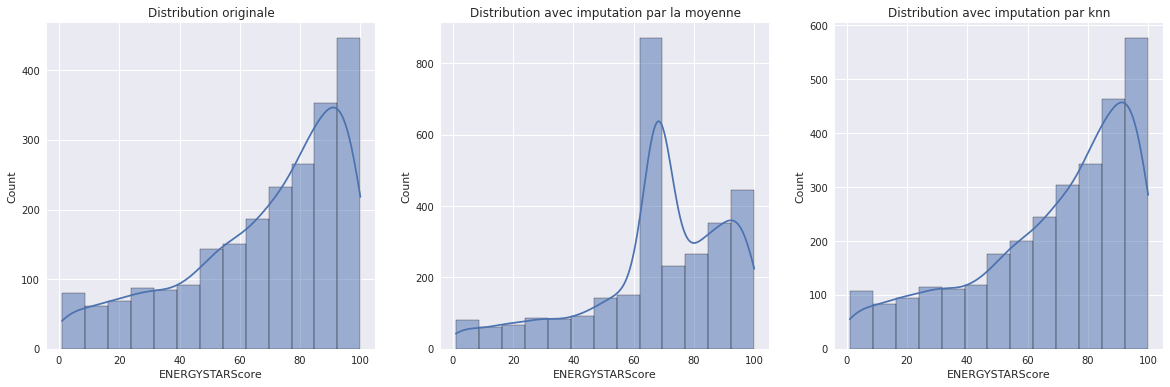

In [79]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

bins = "sturges"
transformed_data_copy = transformed_data.copy().select_dtypes(["int", "float"])
simple_imputer = SimpleImputer(strategy="mean")
simple_imputed_ENERGYSTARScore = pd.DataFrame(np.round_(simple_imputer.fit_transform(transformed_data_copy)),columns=transformed_data_copy.columns, index=transformed_data.index )
knn_imputer = KNNImputer(weights="distance", n_neighbors=1,copy=False)
knn_imputed_ENERGYSTARScore = pd.DataFrame(np.round_(knn_imputer.fit_transform(transformed_data_copy)),columns=transformed_data_copy.columns, index=transformed_data.index)

fig, axes = plt.subplots(ncols=3, figsize=(20,6))

#original distribution
sns.histplot(ax=axes[0], data=transformed_data, x="ENERGYSTARScore", bins=bins, kde=True)
axes[0].set_title("Distribution originale")

#Imputed with mean
sns.histplot(ax=axes[1], data=simple_imputed_ENERGYSTARScore,  x="ENERGYSTARScore", bins=bins, kde=True)
axes[1].set_title("Distribution avec imputation par la moyenne")

#inputed with KNN 
sns.histplot(ax=axes[2], data=knn_imputed_ENERGYSTARScore, x="ENERGYSTARScore", bins=bins, kde=True)
axes[2].set_title("Distribution avec imputation par knn")

plt.show()

La distribution par imputation par KNN semble plus proche de la distribution normale. Nous vérifions en comparant les boites à moustaches de la distribution originale et de la distribution imputée par KNN.

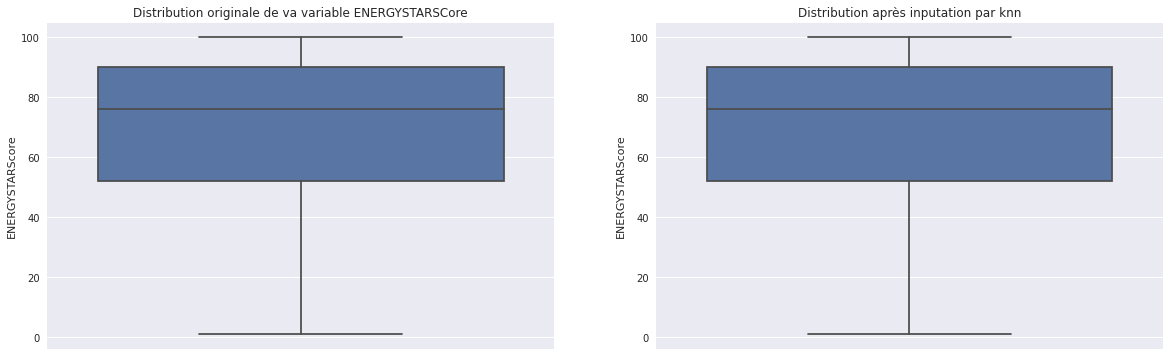

In [80]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

#original distribution
sns.boxplot(ax=axes[0], data=transformed_data, y="ENERGYSTARScore")
axes[0].set_title("Distribution originale de va variable ENERGYSTARSCore")

#inputed by knn 
sns.boxplot(ax=axes[1], data=knn_imputed_ENERGYSTARScore, y="ENERGYSTARScore")
axes[1].set_title("Distribution après inputation par knn")
                  
plt.show()

Les distributions semblent identiques. Nous remplaçons donc la variable originale par son imputation.

In [81]:
transformed_data["ENERGYSTARScore"] = knn_imputed_ENERGYSTARScore["ENERGYSTARScore"]

## Filtrage final des données

Afin d'entrainer les modèles, nous conservons les variables / types de variables suivant(e)s:
- YearBuilt
- PropertyGFATotal
- more_one_building
- PropertyUseTypes
- Proportions de surface d'activités
- Proporsions de consommation d'énergie
- ENERGYSTARScore
- Valeur à prédire : SiteEnergyUseWN(kBtu) et GHGEmissions(MetricTonsCO2e)


In [82]:
rename_dict = { 
                   "Multifamily Housing":"Multifamily Housing_prop",
                    "Non-Refrigerated Warehouse":"Non-Refrigerated Warehouse_prop",
                    "Worship Facility":"Worship Facility_prop" ,
                    "Automobile Dealership" : "Automobile Dealership_prop",
                    "Self-Storage Facility":"Self-Storage Facility_prop" ,
                    "Distribution Center":"Distribution Center_prop",
                    "K-12 School":"K-12 School_prop",
                    "Supermarket/Grocery Store":"Supermarket/Grocery Store_prop" ,
                    "Hotel":"Hotel_prop",
                    "Other":"Other_prop",
                    "Parking":"Parking_prop",
                    "Hospital (General Medical & Surgical)":"Hospital (General Medical & Surgical)_prop" ,
                    "Laboratory":"Laboratory_prop",
                    "Restaurant":"Restaurant_prop",
                     "Office":"Office_prop",
                     "Electricity(kBtu)" : "Electricity(kBtu)_prop",
                     "NaturalGas(kBtu)" : "NaturalGas(kBtu)_prop",
                     "SteamUse(kBtu)": "SteamUse(kBtu)_prop",
                     "OtherFuelUse(kBtu)" : "OtherFuelUse(kBtu)_prop",
                }

transformed_data.rename(columns=rename_dict, inplace=True)

cols_to_save = [
                "YearBuilt",
                "PropertyGFATotal",
                "GFA_by_floor",
                "more_one_building",
                "PropertyUseTypes",
                "Multifamily Housing_prop",
                "Non-Refrigerated Warehouse_prop",
                "Worship Facility_prop" ,
                "Self-Storage Facility_prop" ,
                "Distribution Center_prop",
                "K-12 School_prop",
                "Supermarket/Grocery Store_prop" ,
                "Hotel_prop",
                "Other_prop",
                "Parking_prop",
                "Hospital (General Medical & Surgical)_prop" ,
                "Laboratory_prop",
                "Restaurant_prop",
                "Automobile Dealership_prop",
                "Office_prop",
                "Electricity(kBtu)_prop",
                "NaturalGas(kBtu)_prop",
                "SteamUse(kBtu)_prop",
                "ENERGYSTARScore",
                "SiteEnergyUseWN(kBtu)",
                "GHGEmissions(MetricTonsCO2e)",
                ]

final_data = transformed_data.loc[:,cols_to_save]
display(final_data.head())
print(f"Nombre d'observations restantes: {final_data.shape[0]}")
print(f"Nombre de variables restantes: {final_data.shape[1]}")

,YearBuilt,PropertyGFATotal,GFA_by_floor,more_one_building,PropertyUseTypes,Multifamily Housing_prop,Non-Refrigerated Warehouse_prop,Worship Facility_prop,Self-Storage Facility_prop,Distribution Center_prop,K-12 School_prop,Supermarket/Grocery Store_prop,Hotel_prop,Other_prop,Parking_prop,Hospital (General Medical & Surgical)_prop,Laboratory_prop,Restaurant_prop,Automobile Dealership_prop,Office_prop,Electricity(kBtu)_prop,NaturalGas(kBtu)_prop,SteamUse(kBtu)_prop,ENERGYSTARScore,SiteEnergyUseWN(kBtu),GHGEmissions(MetricTonsCO2e)
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1927,88434,7370.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,51.94,17.93,28.50,65.0,7097539.0,249.43
2,1996,103566,9415.0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.99,0.0,14.55,0.0,0.0,4.46,0.0,0.0,44.55,50.75,0.00,51.0,8765788.0,263.51
3,1969,961990,23463.0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.72,0.0,10.40,0.0,0.0,0.00,0.0,0.0,65.91,4.91,26.04,18.0,75506272.0,2061.48
9,1999,97288,48644.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,55.74,36.65,0.00,99.0,13045258.0,304.62
10,1926,83008,7546.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.01,0.0,0.00,0.0,0.0,0.00,0.0,0.0,41.37,55.16,0.00,25.0,6477493.0,208.46


Nombre d'observations restantes: 2933
Nombre de variables restantes: 26


Réalisons un dernier test de complétions sur l'ensemble des varibales retenues

In [83]:
test_completion(final_data)

,Taux de complétion,Nombre de valeurs manquantes
YearBuilt,100.0,0
PropertyGFATotal,100.0,0
SiteEnergyUseWN(kBtu),100.0,0
ENERGYSTARScore,100.0,0
SteamUse(kBtu)_prop,100.0,0
NaturalGas(kBtu)_prop,100.0,0
Electricity(kBtu)_prop,100.0,0
Office_prop,100.0,0
Automobile Dealership_prop,100.0,0
Restaurant_prop,100.0,0


Enfin sauvegardons les données dans un fichier csv

In [84]:
final_data.to_csv("data_2015.csv")

Nous arrêtons là te traitement et sauvegardons les données dans fichier csv.

## Script de Nettoyage des données et construction des variables.

In [85]:
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer




def transform_list_col(row, col, pattern=None):
    """
    Transform a series with values as list of words to count of words
    
    Args:
        row(Dataframe row): A row of a dataframe
        
        col(string): Name a of dataframe Series
        
        pattern(string): A regex pattern if capture specific caracters 
        
    Returns:
        Number of elements of the list
    """
    import re
    
    pattern = re.compile(pattern)
    if row[col] is np.nan:
        return 1
    if len(pattern.findall(str(row[col]))) == 0:
        return len(row[col].split(","))
    else:
        cleaned = pattern.findall(str(row[col]))[0][0]
        return len(cleaned.split(","))
    


def t_test_comparison(data, cols_to_compair, predicted_col):
    """
    
    Compair t-test statistics and p-values between différent variables againts a single target.
    
    Args:
        data(dataframe) : A dataframe used for t-test on some variables
        
        cols_to_compaire(list of string) : List of varibales used for t-test comparison
        
        predicted_col(string): Name of the target variable
        
    Returns :
        Dataframe with satistic and p-value for each variable
    """
    res = {}
    res["variable"] = []
    res["statistic"] = []
    res["pvalue"] = []
    
    for col in cols_to_compair:
        comp = ttest_ind(data[data[col]==0][predicted_col], data[data[col]==1][predicted_col], equal_var=False )
        res["variable"].append(col)
        res["statistic"].append(comp.statistic)
        res["pvalue"].append(comp.pvalue)
        
    results = pd.DataFrame(data=res)
        
    return results.sort_values(by=["statistic", "pvalue"], ascending=[False, True])


def transform_activities_cols(row, col, type_cols, area_cols, total_area_col):
    """
    Transforms binariy activity variable by computing proportion of GFA of the activity regarding UseType rank.
    
    Args:
        row(Row of dataframe): row of the dataframe used to transform binayry activity variable
        
        col(string): Name of the column to transform
        
       type_cols(list) : Names of UseTypes columns
       
       areas_cols(list): Names of area columns
        
        total_area_col(string): Name of total area column
        
    Returns:
        Transformed value  
    """
    
    

    if row[col] == 1:
        
        #check which is the relevent col in aera_cols to compute aera proportion

        which_col = [row[type_col] for type_col in type_cols]
        idx = which_col.index(col)
        

        if row[area_cols[idx]] != np.nan:
            return round((row[area_cols[idx]]/row[total_area_col])*100,2)
        elif idx == 0 :
            return 100
        else:
            return 0
    
    if row[col]== 0:
        return 0
           

def transform_prop_col(row, source_prop, col):
    """
    Transform a quantative variable into a proportion of another one. Must be used with on a daframe with an apply function.
    
    Args:
    
        row(row DataFrame): Row to transform
        
        source_prop(string): Name of the column to use to build proportions 
        
        col(string): Column name to transform
        
    Returns 
        
        Transformed value of the column
    """

    return round((row[col]/row[source_prop] * 100),2)

data = pd.read_csv("2016-building-energy-benchmarking.csv", index_col="OSEBuildingID")


if "TotalGHGEmissions" in data.columns:
    data["GHGEmissions(MetricTonsCO2e)"] = data["TotalGHGEmissions"]


to_predict_zero = data[(data["SiteEnergyUseWN(kBtu)"] == 0) | (data["GHGEmissions(MetricTonsCO2e)"] == 0)]
to_predict_na = data[(data["SiteEnergyUseWN(kBtu)"].isna()) | (data["GHGEmissions(MetricTonsCO2e)"].isna())]
idx_zero = set(to_predict_zero.index)
idx_na = set(to_predict_na.index)
idx_to_drop = idx_zero | idx_na
data.drop(axis = 0, index=idx_to_drop, inplace = True)
outliers_cols = data[data["Outlier"].notna()].index
data.drop(index= outliers_cols, columns="Outlier", inplace=True)
LargestPropertyUseType_outliers = data[data["LargestPropertyUseTypeGFA"] > data["PropertyGFATotal"]]
data.drop(index=LargestPropertyUseType_outliers.index, inplace=True)
negative_parking_outliers = data[data["PropertyGFAParking"]<0]
data.drop(index=negative_parking_outliers.index, inplace=True)
data.drop(index=21611, inplace=True)


data["PropertyUseTypes"] = data.apply(transform_list_col, col="ListOfAllPropertyUseTypes", pattern="(^.*)\(.*\)(.*$)", axis=1)

selected_cols = [ 
                 "LargestPropertyUseType",
                 "SecondLargestPropertyUseType", 
                 "ThirdLargestPropertyUseType"
                ]

one_hot = OneHotEncoder(dtype=int, sparse=False)

transformed_activities = pd.DataFrame(one_hot.fit_transform(data.loc[:,selected_cols]), columns=one_hot.get_feature_names(), index=data.index )

prefixes = ["x0_", "x1_", "x2_"]


pattern = re.compile("^x\d_(?P<activity>.*)$")
activities = transformed_activities.columns
activities_wo_prefix = set([re.match(pattern, activity).group("activity") if isinstance(activity, str) else np.nan for activity in activities])


all_activities = pd.DataFrame(index=data.index)



for activity in activities_wo_prefix:
    all_activities[f"{activity}"] = data.apply(lambda x: (int((x[selected_cols[0]] == activity) or (x[selected_cols[1]] == activity) or (x[selected_cols[2]] == activity))), axis=1)


transformed_data = pd.concat([data, all_activities], axis=1)

officies = ["Large Office", "Small- and Mid-Sized Office"]
families = ["Low-Rise Multifamily","Mid-Rise Multifamily", "High-Rise Multifamily"]


transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] == x["LargestPropertyUseType"]) else x["PrimaryPropertyType"], axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] != "SPS-District K-12") else "K-12 School" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] != "Hospital") else "Hospital (General Medical & Surgical)" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] not in officies) else "Office" , axis=1)
transformed_data["LargestPropertyUseType"] = transformed_data.apply(lambda x: x["LargestPropertyUseType"] if (x["LargestPropertyUseType"] not in families) else "Multifamily Housing" , axis=1)
transformed_data.loc[(transformed_data["LargestPropertyUseTypeGFA"].isna()==1),"LargestPropertyUseTypeGFA"] = 0
transformed_data.loc[(transformed_data["SecondLargestPropertyUseTypeGFA"].isna()==1),"SecondLargestPropertyUseTypeGFA"] = 0
transformed_data.loc[(transformed_data["ThirdLargestPropertyUseTypeGFA"].isna()==1),"ThirdLargestPropertyUseTypeGFA"] = 0
transformed_data["LargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["LargestPropertyUseTypeGFA"] if (x["LargestPropertyUseTypeGFA"] == x["LargestPropertyUseTypeGFA"]) else x["PropertyGFATotal"], axis=1)
transformed_data["SecondLargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["SecondLargestPropertyUseTypeGFA"] if (x["SecondLargestPropertyUseTypeGFA"] == x["SecondLargestPropertyUseTypeGFA"]) else 0, axis=1)
transformed_data["ThirdLargestPropertyUseTypeGFA"] = transformed_data.apply(lambda x: x["ThirdLargestPropertyUseTypeGFA"] if (x["ThirdLargestPropertyUseTypeGFA"] == x["ThirdLargestPropertyUseTypeGFA"]) else 0, axis=1)


type_cols = [
              "LargestPropertyUseType",
              "SecondLargestPropertyUseType",
              "ThirdLargestPropertyUseType"
            ]
        
aera_cols = [
                "LargestPropertyUseTypeGFA",
                "SecondLargestPropertyUseTypeGFA",
                "ThirdLargestPropertyUseTypeGFA"
                ]


activities_cols = [
                    "Self-Storage Facility",
                    "Multifamily Housing",
                    "Non-Refrigerated Warehouse",
                    "Worship Facility",
                    "Automobile Dealership",
                    "Distribution Center",
                    "K-12 School",
                    "Supermarket/Grocery Store",
                    "Hotel",
                    "Other",
                    "Parking",
                    "Hospital (General Medical & Surgical)",
                    "Laboratory",
                    "Restaurant",
                    "Office"
                ]


for activity_col in activities_cols:
    transformed_data[activity_col] = transformed_data.apply(func=transform_activities_cols, col=activity_col, type_cols=type_cols,  area_cols=aera_cols, total_area_col="PropertyGFATotal", axis=1) 

    
cols = ["SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)"]
rename_dict = {}
for col in cols:
    transformed_data[col] = transformed_data.apply(transform_prop_col, axis=1, source_prop="SiteEnergyUseWN(kBtu)", col=col)
    rename_dict[col] = col + "_prop"


transformed_data["NumberofFloors"] = transformed_data["NumberofFloors"].apply(lambda x: transformed_data['NumberofFloors'].mode() if np.isnan(x) else (1 if x == 0 else x))
transformed_data["GFA_by_floor"] = round(transformed_data["PropertyGFATotal"] / transformed_data["NumberofFloors"].astype("int"))
transformed_data.drop(columns="NumberofFloors", inplace=True)

transformed_data["more_one_building"] = (transformed_data["NumberofBuildings"]>1).astype(int)
transformed_data.drop(columns="NumberofBuildings", inplace=True)

rename_dict = { 
                   "Multifamily Housing":"Multifamily Housing_prop",
                    "Non-Refrigerated Warehouse":"Non-Refrigerated Warehouse_prop",
                    "Worship Facility":"Worship Facility_prop" ,
                    "Automobile Dealership" : "Automobile Dealership_prop",
                    "Self-Storage Facility":"Self-Storage Facility_prop" ,
                    "Distribution Center":"Distribution Center_prop",
                    "K-12 School":"K-12 School_prop",
                    "Supermarket/Grocery Store":"Supermarket/Grocery Store_prop" ,
                    "Hotel":"Hotel_prop",
                    "Other":"Other_prop",
                    "Parking":"Parking_prop",
                    "Hospital (General Medical & Surgical)":"Hospital (General Medical & Surgical)_prop" ,
                    "Laboratory":"Laboratory_prop",
                    "Restaurant":"Restaurant_prop",
                     "Office":"Office_prop",
                     "Electricity(kBtu)" : "Electricity(kBtu)_prop",
                     "NaturalGas(kBtu)" : "NaturalGas(kBtu)_prop",
                     "SteamUse(kBtu)": "SteamUse(kBtu)_prop",
                     "OtherFuelUse(kBtu)" : "OtherFuelUse(kBtu)_prop",
                }

transformed_data.rename(columns=rename_dict, inplace=True)

cols_to_save = [
                "YearBuilt",
                "PropertyGFATotal",
                "GFA_by_floor",
                "more_one_building",
                "PropertyUseTypes",
                "LargestPropertyUseType",
                "Multifamily Housing_prop",
                "Non-Refrigerated Warehouse_prop",
                "Worship Facility_prop" ,
                "Self-Storage Facility_prop" ,
                "Distribution Center_prop",
                "K-12 School_prop",
                "Supermarket/Grocery Store_prop" ,
                "Hotel_prop",
                "Other_prop",
                "Parking_prop",
                "Hospital (General Medical & Surgical)_prop" ,
                "Laboratory_prop",
                "Restaurant_prop",
                "Automobile Dealership_prop",
                "Office_prop",
                "Electricity(kBtu)_prop",
                "NaturalGas(kBtu)_prop",
                "SteamUse(kBtu)_prop",
                "ENERGYSTARScore",
                "SiteEnergyUseWN(kBtu)",
                "GHGEmissions(MetricTonsCO2e)",
                ]

final_data = transformed_data.loc[:,cols_to_save]
                                                           

final_data_copy = final_data.copy().select_dtypes(["int", "float"])
knn_imputer = KNNImputer(weights="distance", n_neighbors=1,copy=False)
knn_imputed_ENERGYSTARScore = pd.DataFrame(np.round_(knn_imputer.fit_transform(final_data_copy)),columns=final_data_copy.columns, index=final_data.index)
                                                      
                                                      

final_data["ENERGYSTARScore"] = knn_imputed_ENERGYSTARScore["ENERGYSTARScore"]
                                                      


final_data.to_csv("data_2016.csv")